In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import warnings

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')


In [8]:
train_info = train_df.info()
train_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [9]:
train_df.shape


(3960, 82)

The training data has 3960 data points (children who participate in the study) and 82 features counting the id column and the target sii variables 

In [10]:
import pandas as pd

def missing_features_in_test(train_df, test_df):
    """
    Identifies features present in train_df but missing in test_df.
    
    Returns:
    list: List of feature names missing in test_df.
    """
    train_features = set(train_df.columns)
    test_features = set(test_df.columns)
    
    missing_features = list(train_features - test_features)
    
    return missing_features

In [11]:
# Find missing features in test 
missing_features = missing_features_in_test(train_df, test_df)
missing_features

['PCIAT-PCIAT_11',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_Total',
 'sii',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_04',
 'PCIAT-Season',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_05']

In [12]:
sii = train_df['sii']
sii

0       2.0
1       0.0
2       0.0
3       1.0
4       NaN
5       1.0
6       0.0
7       NaN
8       NaN
9       NaN
10      NaN
11      0.0
12      1.0
13      NaN
14      NaN
15      2.0
16      0.0
17      NaN
18      0.0
19      NaN
20      1.0
21      0.0
22      0.0
23      2.0
24      0.0
25      0.0
26      0.0
27      0.0
28      2.0
29      NaN
30      NaN
31      0.0
32      NaN
33      NaN
34      NaN
35      NaN
36      0.0
37      NaN
38      2.0
39      NaN
40      NaN
41      0.0
42      NaN
43      NaN
44      0.0
45      0.0
46      0.0
47      NaN
48      1.0
49      0.0
50      1.0
51      1.0
52      0.0
53      0.0
54      0.0
55      1.0
56      0.0
57      1.0
58      0.0
59      2.0
60      0.0
61      2.0
62      0.0
63      1.0
64      0.0
65      NaN
66      2.0
67      NaN
68      0.0
69      NaN
70      2.0
71      NaN
72      2.0
73      NaN
74      0.0
75      1.0
76      NaN
77      0.0
78      NaN
79      0.0
80      2.0
81      0.0
82      2.0
83  

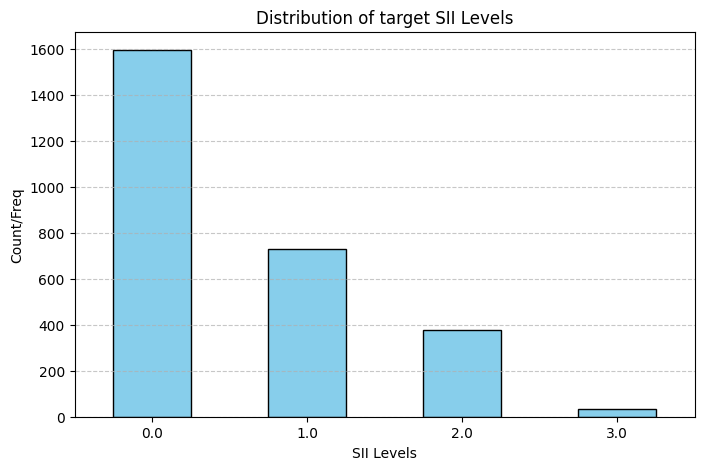

In [13]:
# Plot the distribution of the target 'sii' column
plt.figure(figsize=(8, 5))
train_df['sii'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# Formatting the plot
plt.title('Distribution of target SII Levels')
plt.xlabel('SII Levels')
plt.ylabel('Count/Freq')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Exploring the target class sii that we are trying to predict we can observe that 

In [14]:
# import os
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor
# from tqdm import tqdm

# def extract_file_data(file_path: str) -> tuple:
#     """
#     Reads a Parquet file, removes the 'step' column, and returns statistical summaries.
    
#     Args:
#         file_path (str): The full path to the Parquet file.

#     Returns:
#         tuple: Flattened statistical summary and extracted identifier.
#     """
#     data = pd.read_parquet(file_path)
#     data = data.drop(columns=['step'], errors='ignore')  # Ensure no error if 'step' is missing
#     stats_summary = data.describe().values.flatten()  # Convert statistical summary to a 1D array
    
#     file_id = os.path.basename(file_path).split('=')[1]  # Extract ID from the filename
#     return stats_summary, file_id

# def load_time_series_data(directory: str) -> pd.DataFrame:
#     """
#     Processes multiple time series files in parallel and aggregates statistical summaries.

#     Args:
#         directory (str): Path to the directory containing the time series files.

#     Returns:
#         pd.DataFrame: A DataFrame containing statistical summaries with corresponding IDs.
#     """
#     file_names = os.listdir(directory)

#     with ThreadPoolExecutor() as executor:
#         results = list(tqdm(
#             executor.map(lambda file: extract_file_data(os.path.join(directory, file, 'part-0.parquet')), file_names),
#             total=len(file_names)
#         ))

#     summaries, identifiers = zip(*results)  # Separate statistics and file identifiers

#     summary_df = pd.DataFrame(summaries, columns=[f"Stat_{i}" for i in range(len(summaries[0]))])
#     summary_df['id'] = identifiers

#     return summary_df


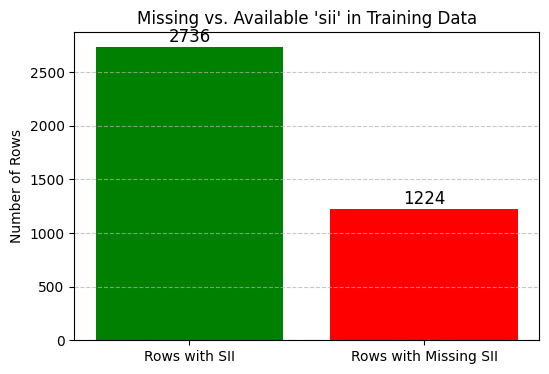

In [15]:
# Re-import necessary libraries since execution state was reset
import pandas as pd
import matplotlib.pyplot as plt

# Function to visualize missing vs. non-missing values in 'sii'
def plot_sii_missing_data(df, column_name="sii"):
    """
    Plots a bar chart showing the number of rows with and without missing values in the given column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The column to check for missing values.
    """
    missing_count = df[column_name].isna().sum()  # Count NaN values
    non_missing_count = len(df) - missing_count   # Count valid values

    # Data for plotting
    labels = ["Rows with SII", "Rows with Missing SII"]
    counts = [non_missing_count, missing_count]

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=['green', 'red'])
    plt.ylabel("Number of Rows")
    plt.title(f"Missing vs. Available '{column_name}' in Training Data")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display values on bars
    for i, v in enumerate(counts):
        plt.text(i, v + 50, str(v), ha='center', fontsize=12)

    plt.show()

plot_sii_missing_data(train_df, column_name="sii") 


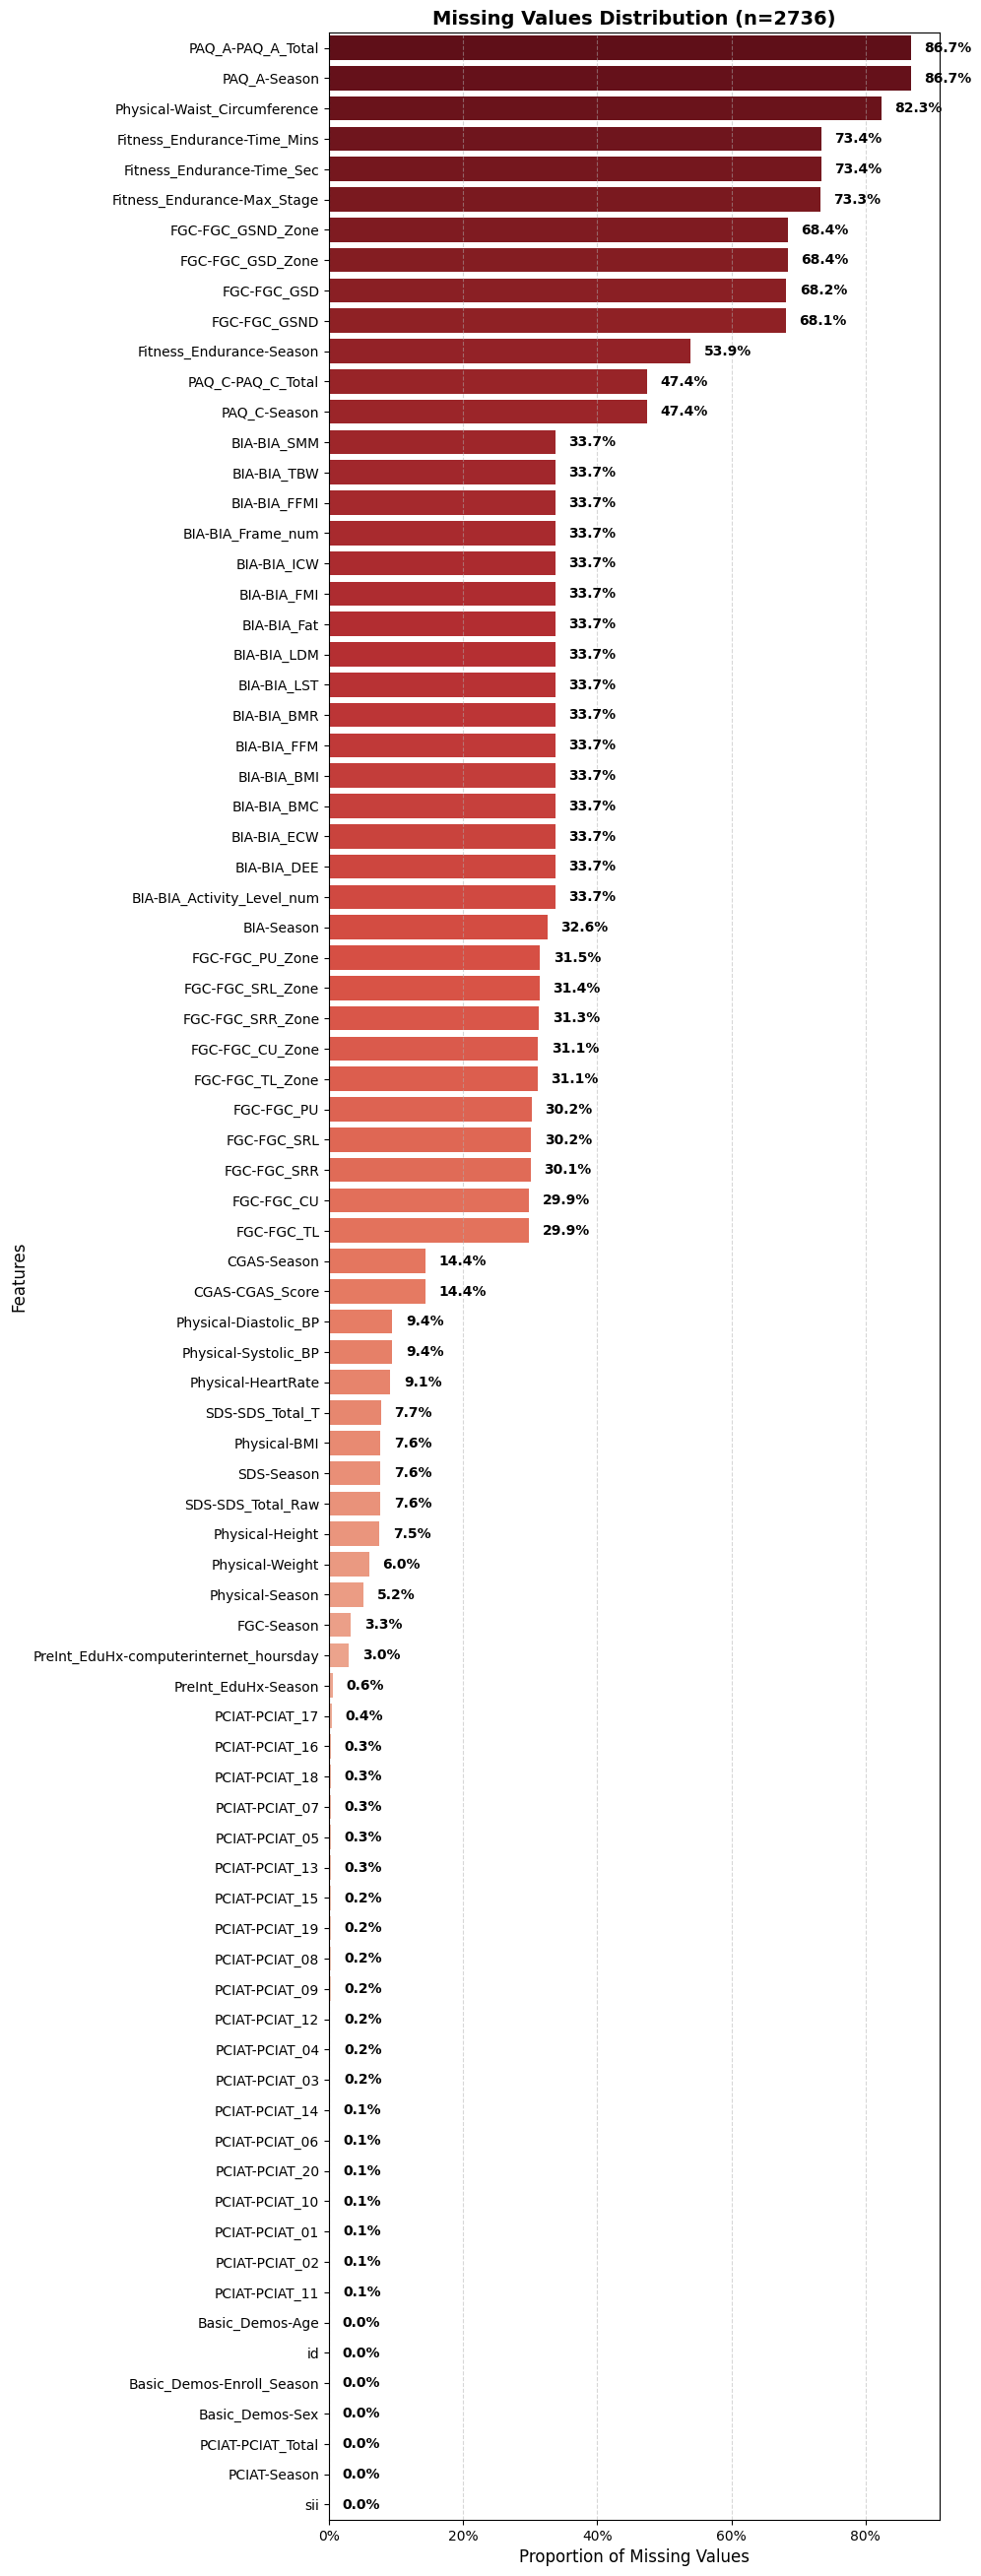

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

def visualize_missing_data(df):
    """Visualizes missing values in samples that have the target label 'sii'."""
    
    # Filter samples where target label 'sii' is available
    target_available = df[df['sii'].notnull()]
    
    # Compute missing value statistics
    missing_stats = target_available.isnull().sum().reset_index()
    missing_stats.columns = ['Feature', 'MissingCount']
    missing_stats['MissingRatio'] = missing_stats['MissingCount'] / len(target_available)
    
    # Sort by missing ratio
    missing_stats = missing_stats.sort_values('MissingRatio', ascending=False)

    # Visualization
    plt.figure(figsize=(8, len(missing_stats) * 0.4))
    plt.title(f"Missing Values Distribution (n={len(target_available)})", fontsize=14, fontweight="bold")

    # Create a gradient color palette
    colors = sns.color_palette("Reds_r", len(missing_stats))

    sns.barplot(
        x=missing_stats['MissingRatio'], 
        y=missing_stats['Feature'], 
        palette=colors
    )

    plt.xlabel("Proportion of Missing Values", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    
    # Add text annotations for better readability
    for i, (ratio, count) in enumerate(zip(missing_stats['MissingRatio'], missing_stats['MissingCount'])):
        plt.text(ratio + 0.02, i, f"{ratio:.1%}", va='center', fontsize=10, color="black", fontweight="bold")

    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.show()

# Call the function
visualize_missing_data(train_df)


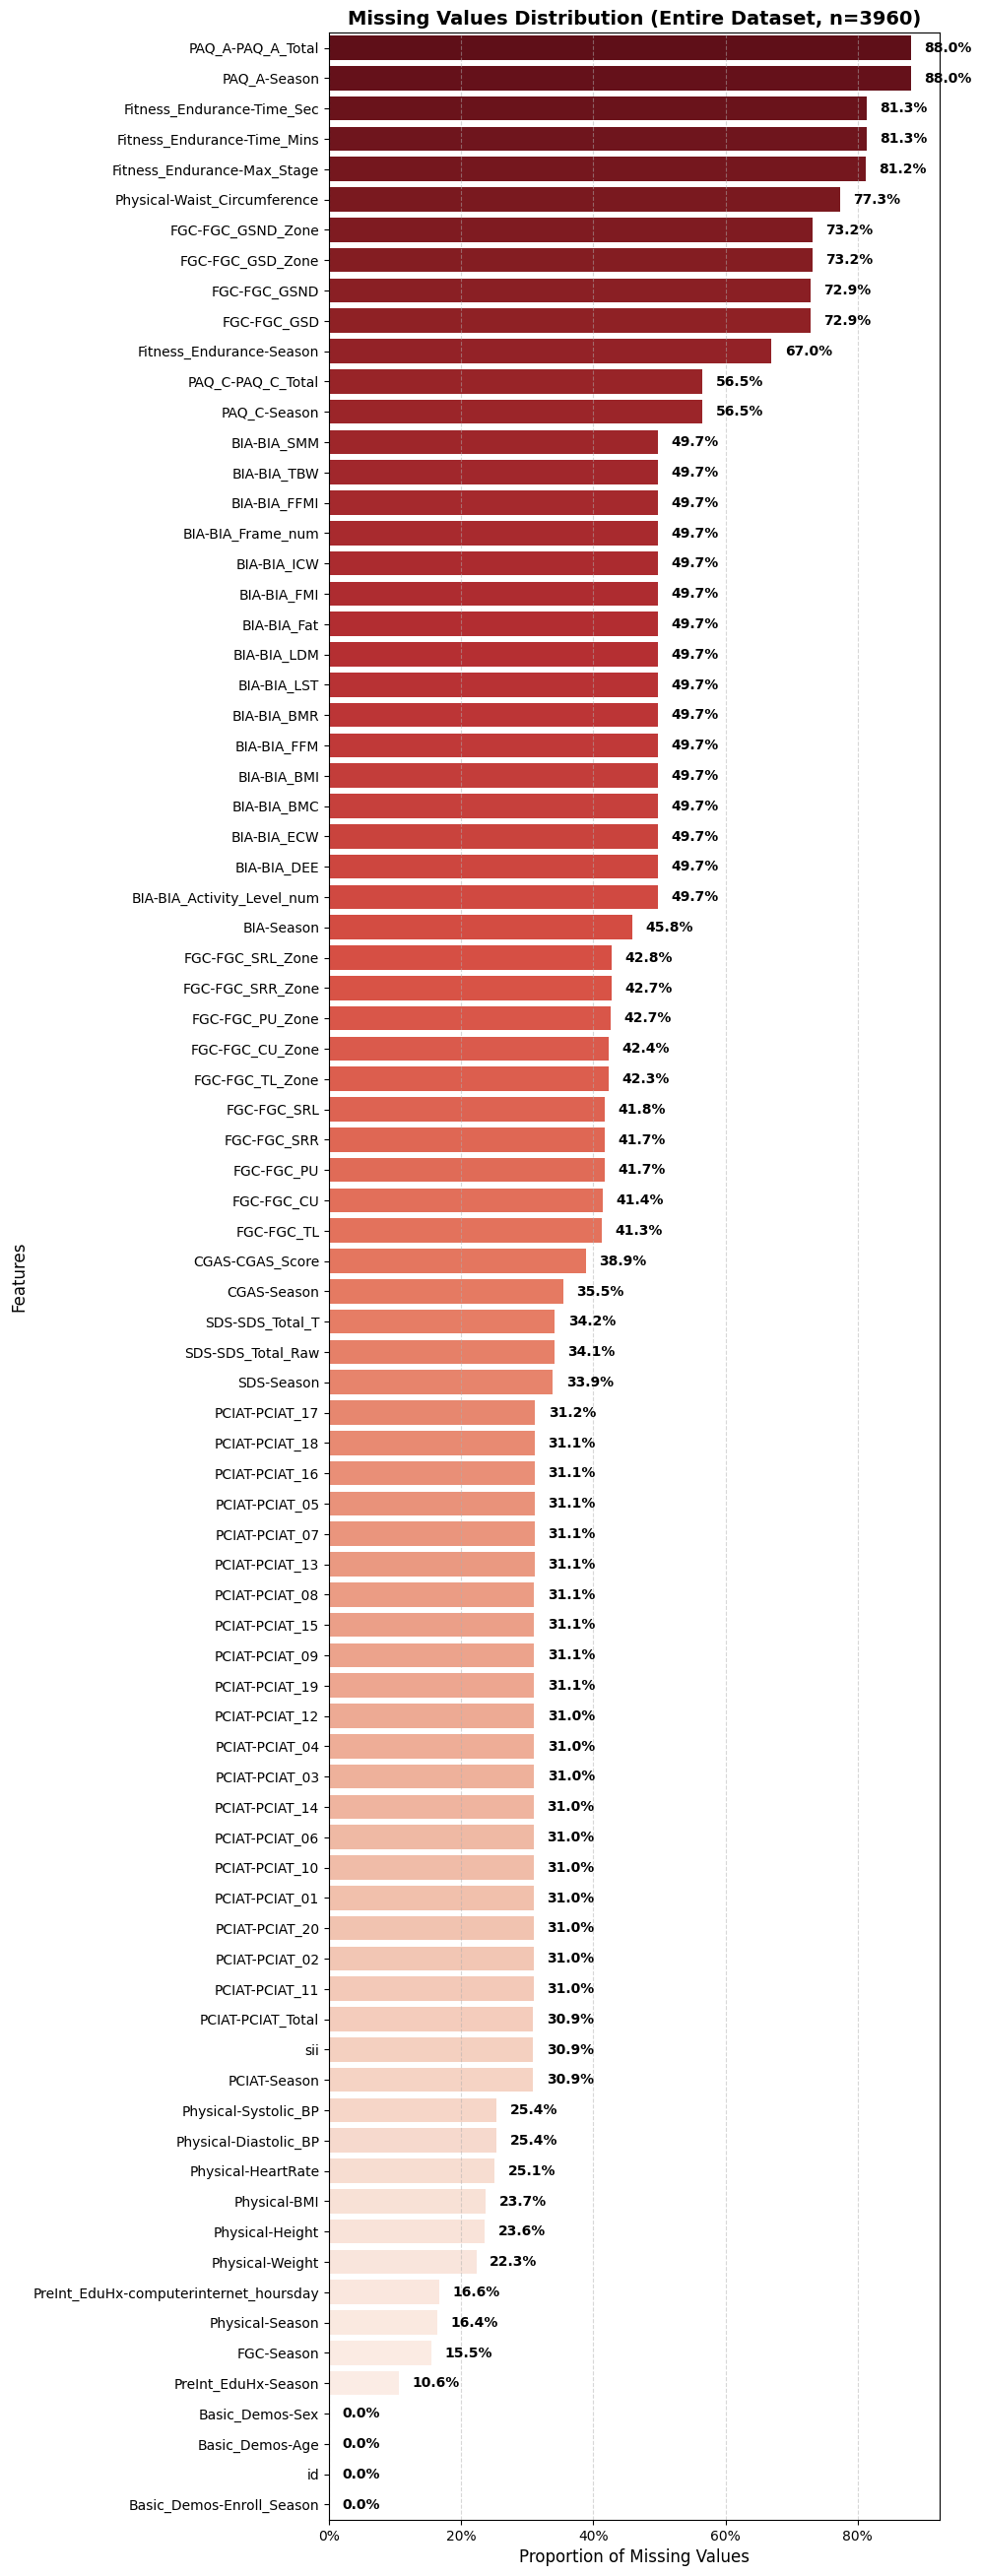

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

def visualize_missing_data_full(df):
    """Visualizes missing values across the entire dataset."""
    
    # Compute missing value statistics
    missing_stats = df.isnull().sum().reset_index()
    missing_stats.columns = ['Feature', 'MissingCount']
    missing_stats['MissingRatio'] = missing_stats['MissingCount'] / len(df)
    
    # Sort by missing ratio
    missing_stats = missing_stats.sort_values('MissingRatio', ascending=False)

    # Visualization
    plt.figure(figsize=(8, len(missing_stats) * 0.4))
    plt.title(f"Missing Values Distribution (Entire Dataset, n={len(df)})", fontsize=14, fontweight="bold")

    # Create a gradient color palette
    colors = sns.color_palette("Reds_r", len(missing_stats))

    sns.barplot(
        x=missing_stats['MissingRatio'], 
        y=missing_stats['Feature'], 
        palette=colors
    )

    plt.xlabel("Proportion of Missing Values", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    
    # Add text annotations for better readability
    for i, (ratio, count) in enumerate(zip(missing_stats['MissingRatio'], missing_stats['MissingCount'])):
        plt.text(ratio + 0.02, i, f"{ratio:.1%}", va='center', fontsize=10, color="black", fontweight="bold")

    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.show()

# Call the function to visualize missing data in the full dataset
visualize_missing_data_full(train_df)


From above EDA, PCIAT-PCIAT_Total is available for all rows that have sii values available. predict PCIAT-PCIAT_Total and then transform this prediction to a sii prediction for model. PCIAT-PCIAT_Total is more granular and informative than sii, training to predict PCIAT-PCIAT_Total has the potential to produce a better model.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def find_physical_correlations(df, target_col, physical_features):
    """
    Identifies and visualizes the correlation of physical features with a target column.

    Args:
        df (pd.DataFrame): The dataset containing features and target variable.
        target_col (str): The column name for the target variable (PCIAT-PCIAT_Total).
        physical_features (list): List of column names representing physical features.

    Returns:
        pd.Series: Sorted correlations of physical features with the target.
    """
    # Compute correlation matrix
    correlation_matrix = df[physical_features + [target_col]].corr()

    # Extract correlations with the target variable
    target_correlations = correlation_matrix[target_col].drop(target_col)

    # Sort by absolute correlation value
    strongest_correlations = target_correlations.abs().sort_values(ascending=False)

    # Visualize as a heatmap
    plt.figure(figsize=(8, 10))
    sns.heatmap(
        strongest_correlations.to_frame(), 
        annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f"
    )
    plt.title(f'Correlation of Physical Features with {target_col}')
    plt.show()

    return strongest_correlations


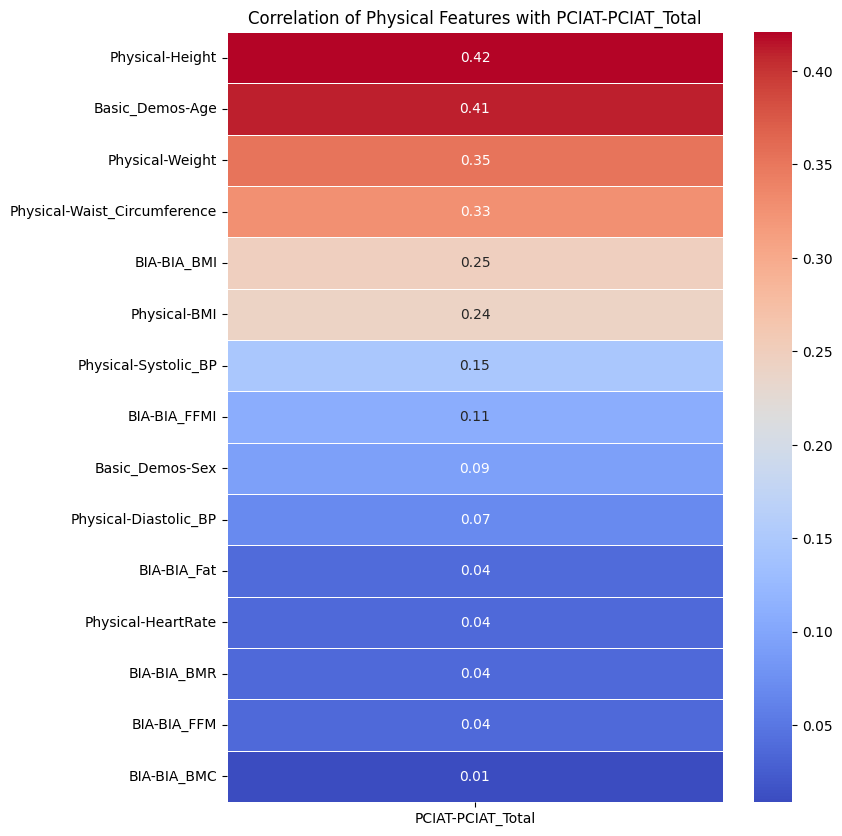

Physical-Height                 0.420765
Basic_Demos-Age                 0.409559
Physical-Weight                 0.353048
Physical-Waist_Circumference    0.327013
BIA-BIA_BMI                     0.248060
Physical-BMI                    0.240858
Physical-Systolic_BP            0.147081
BIA-BIA_FFMI                    0.109694
Name: PCIAT-PCIAT_Total, dtype: float64


In [19]:
physical_columns = [
    'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
    'Physical-Systolic_BP', 'Physical-HeartRate', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 
    'BIA-BIA_BMR', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_Fat'
    # Add more relevant physical features
]

correlation_results = find_physical_correlations(train_df, 'PCIAT-PCIAT_Total', physical_columns)

# Display features with correlation above a certain threshold (e.g., |0.1|)
selected_features = correlation_results[correlation_results.abs() > 0.1]
print(selected_features)


In [20]:
# import os
# import pandas as pd
# import numpy as np
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# # File paths
# train_series_path = "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"
# test_series_path = "/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet"

# def process_file(filename, dirname):
#     """Extracts statistics from a single file using ThreadPoolExecutor."""
#     try:
#         # Load file
#         df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'), engine="pyarrow")
#         df.drop(columns=['step'], errors='ignore', inplace=True)  # Drop 'step' column if it exists

#         # Compute statistics
#         stats_summary = df.describe().values.reshape(-1)  # Flatten statistics
        
#         # Extract file ID
#         file_id = filename.split('=')[1]

#         return stats_summary, file_id

#     except Exception as e:
#         print(f"Error processing {filename}: {e}")
#         return None, None  # Return None for handling errors

# def load_time_series(dirname, max_workers=8, batch_size=250):
#     """
#     Processes multiple files in parallel using ThreadPoolExecutor.

#     Args:
#         dirname (str): Directory containing time series files.
#         max_workers (int): Number of concurrent threads for parallel processing.
#         batch_size (int): Number of files to process per batch.

#     Returns:
#         pd.DataFrame: DataFrame containing extracted statistical summaries with corresponding IDs.
#     """
#     ids = os.listdir(dirname)
#     all_results = []
    
#     # Process files in manageable batches to prevent memory overload
#     for i in range(0, len(ids), batch_size):
#         batch_files = ids[i:i + batch_size]
#         batch_results = []

#         with ThreadPoolExecutor(max_workers=max_workers) as executor:
#             future_to_file = {executor.submit(process_file, fname, dirname): fname for fname in batch_files}

#             for future in tqdm(as_completed(future_to_file), total=len(batch_files), desc=f"Processing Batch {i // batch_size + 1}"):
#                 result = future.result()
#                 if result[0] is not None:  # Only append valid results
#                     batch_results.append(result)
        
#         all_results.extend(batch_results)  # Store batch results

#     # Convert results to DataFrame
#     stats, indexes = zip(*all_results)
#     df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
#     df["id"] = indexes

#     return df

# # Process training and test datasets
# print("Processing Training Data...")
# train_ts_df = load_time_series(train_series_path, max_workers=8, batch_size=250)

# print("Processing Test Data...")
# test_ts_df = load_time_series(test_series_path, max_workers=8, batch_size=250)

# # Display DataFrames
# train_df.head()

In [21]:
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.impute import KNNImputer
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from concurrent.futures import ThreadPoolExecutor
# from tqdm import tqdm
# import warnings
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, Model, Input
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

** AutoEncoder can be used to dimension reduce the time-series dataset, removing irrelavant features and avoid overfitting**

 Basic aggregations (mean, variance, ...) of the time series as features for a gradient-boosting model.

In [22]:
# Set random seeds for reproducibility
def set_random_seeds(seed_value=42):
    """Set random seeds for reproducibility across libraries"""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    # Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_seeds(2025)

#TIME SERIES FEATURE EXTRACTION 

class TimeSeriesProcessor:
    """Class for processing time series data from wearable devices"""
    
    def __init__(self, day_start=6, day_end=18, expected_diff=5):
        self.day_start = day_start
        self.day_end = day_end
        self.expected_diff = expected_diff
        
    def extract_time_features(self, data):
        """Extract time-related features from time series data"""
        # Convert nanoseconds to hours
        data['hour_of_day'] = data['time_of_day'] / 1e9 / 3600
        
        # Calculate continuous time measure
        data['continuous_time'] = data['relative_date_PCIAT'] + data['hour_of_day'] / 24
        
        # Classify as day or night
        data['day_or_night'] = np.where(
            (data['hour_of_day'] >= self.day_start) & 
            (data['hour_of_day'] < self.day_end),
            'daytime', 'nighttime'
        )
        
        # Calculate time differences between measurements
        data['time_difference'] = (data['continuous_time'].diff() * 86400).round(0)
        data['gap_in_measurements'] = data['time_difference'] > self.expected_diff
        
        return data
    
    def analyze_inactive_periods(self, data):
        """Identify and analyze periods of inactivity"""
        # Define inactivity as ENMO = 0
        inactive = data['enmo'] == 0
        
        # Group consecutive inactive periods
        group_id = ((inactive != inactive.shift()) | 
                   (data['gap_in_measurements'])).cumsum()
        
        # Extract inactive periods
        inactive_periods = data[inactive].groupby(group_id)['continuous_time'].agg(['min', 'max'])
        
        # Calculate duration in seconds
        inactive_periods['duration_seconds'] = ((inactive_periods['max'] - 
                                               inactive_periods['min']) * 86400).round(0).astype(int)
        
        # Add 5 seconds to account for sampling window
        inactive_periods['duration_seconds'] += 5
        
        # Assign day
        inactive_periods['day'] = inactive_periods['min'].astype(int)
        
        # Calculate daily statistics
        daily_stats = inactive_periods.groupby('day').agg(
            total_inactive_duration=('duration_seconds', 'sum'),
            inactive_period_count=('duration_seconds', 'size')
        )
        
        return self._collect_statistics(daily_stats)
    
    def analyze_activity_rhythm(self, data):
        """Analyze daily activity patterns and rhythms"""
        # Group activity by day, hour, and day/night period
        hourly = data.groupby([
            data['relative_date_PCIAT'].astype(int),
            data['hour_of_day'].astype(int),
            data['day_or_night']
        ])['enmo'].agg(['mean', 'max'])
        
        # Calculate rhythm metrics
        rhythm_features = hourly['mean'].groupby(level=[0, 2]).agg(
            hourly_variation=lambda x: x.std(),
            peak_hour=lambda x: x.idxmax()[1] if len(x) > 0 else np.nan,
            entropy=lambda x: -((x / x.sum()) * np.log(x / x.sum() + 1e-9)).sum() if x.sum() > 0 else np.nan
        )
        
        # Split day and night metrics
        day_metrics = rhythm_features.xs('daytime', level='day_or_night') if 'daytime' in rhythm_features.index.get_level_values(1) else pd.DataFrame()
        night_metrics = rhythm_features.xs('nighttime', level='day_or_night') if 'nighttime' in rhythm_features.index.get_level_values(1) else pd.DataFrame()
        
        day_stats = self._collect_statistics(day_metrics, prefix="day_")
        night_stats = self._collect_statistics(night_metrics, prefix="night_")
        
        return {**day_stats, **night_stats}
    
    def analyze_physical_activity(self, data, mvpa_threshold=0.1, min_duration=60):
        """Detect and analyze moderate-to-vigorous physical activity periods"""
        # Flag MVPA periods based on threshold
        data['is_mvpa'] = data['enmo'] > mvpa_threshold
        
        # Group consecutive MVPA periods
        mvpa_groups = self._group_activity_periods(data, 'is_mvpa')
        
        # Calculate duration of each MVPA period
        mvpa_periods = data[data['is_mvpa']].groupby(mvpa_groups)['continuous_time'].agg(['min', 'max'])
        mvpa_periods['duration_seconds'] = (mvpa_periods['max'] - mvpa_periods['min']) * 86400
        
        # Filter for significant duration
        mvpa_periods = mvpa_periods[mvpa_periods['duration_seconds'] >= min_duration]
        mvpa_periods['duration_minutes'] = mvpa_periods['duration_seconds'] / 60
        mvpa_periods['day'] = mvpa_periods['min'].astype(int)
        
        # Calculate daily statistics
        daily_stats = mvpa_periods.groupby('day').agg(
            total_mvpa_duration=('duration_seconds', 'sum'),
            mvpa_period_count=('duration_seconds', 'size')
        )
        
        return self._collect_statistics(daily_stats)
    
    def analyze_activity_transitions(self, data, mvpa_threshold=0.1, vig_threshold=0.5, min_duration=60):
        """Analyze transitions between activity intensity levels"""
        # Categorize activity levels
        data['activity_level'] = pd.cut(
            data['enmo'],
            bins=[-np.inf, mvpa_threshold, vig_threshold, np.inf],
            labels=['low', 'moderate', 'vigorous']
        )
        
        # Group consecutive periods of same activity level
        activity_groups = ((data['activity_level'] != data['activity_level'].shift()) | 
                          (data['gap_in_measurements'])).cumsum()
        
        # Calculate duration of each activity period
        activity_periods = data.groupby(activity_groups).agg(
            start_time=('continuous_time', 'min'),
            end_time=('continuous_time', 'max'),
            activity_type=('activity_level', 'first')
        )
        
        activity_periods['duration_seconds'] = (activity_periods['end_time'] - 
                                              activity_periods['start_time']) * 86400 + 5
        
        # Filter for significant duration
        activity_periods = activity_periods[activity_periods['duration_seconds'] >= min_duration]
        activity_periods['duration_minutes'] = activity_periods['duration_seconds'] / 60
        activity_periods['day'] = activity_periods['start_time'].astype(int)
        
        # Calculate transitions separately to avoid the error
        # First, add a group column to identify each day
        activity_periods = activity_periods.reset_index()  # Reset index for the groupby operation
        
        # Process each day separately
        days = activity_periods['day'].unique()
        transition_counts = []
        
        for day in days:
            day_data = activity_periods[activity_periods['day'] == day]
            if len(day_data) > 0:
                # Count transitions as changes in activity type
                transitions = (day_data['activity_type'] != day_data['activity_type'].shift()).sum()
                transition_counts.append({'day': day, 'daily_transitions': transitions})
        
        # Convert to DataFrame
        transition_df = pd.DataFrame(transition_counts).set_index('day')
        
        # Calculate statistics by activity type
        low_activity = activity_periods[activity_periods['activity_type'] == 'low'].groupby('day').agg(
            low_activity_duration=('duration_seconds', 'sum'),
            low_activity_count=('duration_seconds', 'size')
        )
        
        moderate_activity = activity_periods[activity_periods['activity_type'] == 'moderate'].groupby('day').agg(
            moderate_activity_duration=('duration_seconds', 'sum'),
            moderate_activity_count=('duration_seconds', 'size')
        )
        
        # Collect statistics from each DataFrame
        low_stats = self._collect_statistics(low_activity)
        mod_stats = self._collect_statistics(moderate_activity)
        trans_stats = self._collect_statistics(transition_df)
        
        return {**low_stats, **mod_stats, **trans_stats}
    
    def analyze_light_activity_relationship(self, data):
        """Calculate correlation between light exposure and physical activity"""
        correlation = data[['light', 'enmo']].corr().iloc[0, 1]
        return {'light_activity_correlation': correlation}
    
    def _group_activity_periods(self, data, activity_flag_col, allowed_gap=60):
        """Helper method to group consecutive activity periods"""
        # Find the last activity time
        last_activity_time = data[activity_flag_col].where(data[activity_flag_col]).ffill().shift()
        
        # Calculate time since last activity
        time_since_last = ((data['continuous_time'] - last_activity_time) * 86400).round(0)
        
        # Determine new groups based on activity change or time gap
        activity_group = ((data[activity_flag_col] != data[activity_flag_col].shift()) | 
                         (data['time_difference'] >= allowed_gap)).cumsum()
        
        # Identify start of new activity periods
        is_new_period = ((activity_group != activity_group.shift()) & data[activity_flag_col])
        
        # Group activities that should be merged
        should_merge = is_new_period & ((time_since_last < allowed_gap) & ~last_activity_time.isnull())
        
        merged_group = is_new_period.cumsum()
        merged_group.loc[~data[activity_flag_col]] = np.nan
        
        return merged_group
    
    def _collect_statistics(self, df, prefix=""):
        """Helper method to collect statistics from a DataFrame"""
        if df.empty:
            return {}
            
        stats = df.agg(['mean', 'median', 'max', 'std']).to_dict()
        
        flattened_stats = {}
        for col, metrics in stats.items():
            for metric_name, value in metrics.items():
                key = f"{metric_name}_{col}"
                if prefix:
                    key = f"{prefix}{key}"
                flattened_stats[key] = value
                
        return flattened_stats
    
    def process_participant_data(self, file_path, participant_id):
        """Process all data for a single participant"""
        # Load data
        data = pd.read_parquet(file_path)
        
        # Extract time features
        self.extract_time_features(data)
        
        # Calculate non-wear percentage
        non_wear_percentage = (data['non-wear_flag'].sum() / len(data)) * 100
        
        # Filter for worn data only
        worn_data = data[data['non-wear_flag'] == 0]
        
        # Recalculate time features for worn data only
        worn_data['time_difference'] = (worn_data['continuous_time'].diff() * 86400).round(0)
        worn_data['gap_in_measurements'] = worn_data['time_difference'] > self.expected_diff
        
        # Analyze various aspects of the time series
        inactive_stats = self.analyze_inactive_periods(worn_data)
        rhythm_stats = self.analyze_activity_rhythm(worn_data)
        activity_stats = self.analyze_physical_activity(worn_data)
        transition_stats = self.analyze_activity_transitions(worn_data)
        light_activity_stats = self.analyze_light_activity_relationship(worn_data)
        
        # Combine all statistics
        participant_stats = {
            'id': participant_id,
            'non_wear_percentage': non_wear_percentage
        }
        
        participant_stats.update(inactive_stats)
        participant_stats.update(rhythm_stats)
        participant_stats.update(activity_stats)
        participant_stats.update(transition_stats)
        participant_stats.update(light_activity_stats)
        
        return participant_stats
    
    def process_dataset(self, directory):
        """Process all participants in a dataset"""
        participant_ids = os.listdir(directory)
        
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(
                executor.map(
                    lambda x: self.process_participant_data(
                        os.path.join(directory, x, 'part-0.parquet'), 
                        x
                    ), 
                    participant_ids
                ), 
                total=len(participant_ids)
            ))
            
        # Convert to DataFrame
        df = pd.DataFrame(results)
        
        # Handle infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Fill NaN values with 0
        df.fillna(0, inplace=True)
        
        return df

In [23]:
class OptimizedTimeSeriesProcessor:
    """Optimized class for processing time series data while preserving important patterns"""
    
    def __init__(self, day_start=6, day_end=18, expected_diff=5):
        self.day_start = day_start
        self.day_end = day_end
        self.expected_diff = expected_diff
        
    def extract_time_features(self, data):
        """Extract time-related features from time series data"""
        # Convert nanoseconds to hours in one step
        data['hour_of_day'] = data['time_of_day'] / 1e9 / 3600
        data['continuous_time'] = data['relative_date_PCIAT'] + data['hour_of_day'] / 24
        data['day_or_night'] = np.where(
            (data['hour_of_day'] >= self.day_start) & 
            (data['hour_of_day'] < self.day_end),
            'daytime', 'nighttime'
        )
        
        # Calculate time differences between measurements (vectorized)
        data['time_difference'] = (data['continuous_time'].diff() * 86400).round(0)
        data['gap_in_measurements'] = data['time_difference'] > self.expected_diff
        
        return data
    
    def extract_key_metrics(self, data):
        """Extract the most informative metrics from the time series data"""
        # Daily activity patterns
        daily_metrics = data.groupby(data['continuous_time'].astype(int)).agg(
            mean_enmo=('enmo', 'mean'),
            max_enmo=('enmo', 'max'),
            std_enmo=('enmo', 'std'),
            mean_light=('light', 'mean')
        )
        
        # Day vs night activity
        day_data = data[data['day_or_night'] == 'daytime']
        night_data = data[data['day_or_night'] == 'nighttime']
        
        day_activity = day_data['enmo'].mean() if not day_data.empty else 0
        night_activity = night_data['enmo'].mean() if not night_data.empty else 0
        day_night_ratio = day_activity / max(night_activity, 0.001)
        
        # Activity intensity distribution
        mvpa_threshold = 0.1
        vig_threshold = 0.5
        
        sedentary_pct = (data['enmo'] < mvpa_threshold).mean() * 100
        moderate_pct = ((data['enmo'] >= mvpa_threshold) & (data['enmo'] < vig_threshold)).mean() * 100
        vigorous_pct = (data['enmo'] >= vig_threshold).mean() * 100
        
        # Activity bout detection (simplified)
        is_active = data['enmo'] > mvpa_threshold
        activity_changes = (is_active != is_active.shift()).sum()
        active_bouts = activity_changes / 2  # Each bout has a start and end change
        
        # Inactivity analysis
        inactive_periods = (data['enmo'] == 0).sum() / len(data) * 100
        
        # Light-activity correlation
        light_activity_corr = np.corrcoef(data['light'].values, data['enmo'].values)[0, 1]
        
        # Circadian rhythm indicators
        hourly_activity = data.groupby(data['hour_of_day'].astype(int))['enmo'].mean()
        peak_hour = hourly_activity.idxmax() if not hourly_activity.empty else 0
        activity_range = hourly_activity.max() - hourly_activity.min() if not hourly_activity.empty else 0
        
        # Combine all metrics
        metrics = {
            'day_night_ratio': day_night_ratio,
            'sedentary_percentage': sedentary_pct,
            'moderate_percentage': moderate_pct,
            'vigorous_percentage': vigorous_pct,
            'active_bouts': active_bouts,
            'inactive_periods_pct': inactive_periods,
            'light_activity_correlation': light_activity_corr,
            'peak_activity_hour': peak_hour,
            'activity_range': activity_range
        }
        
        # Add summary statistics from daily metrics
        daily_stats = self._collect_statistics(daily_metrics)
        metrics.update(daily_stats)
        
        return metrics
    
    def _collect_statistics(self, df, prefix=""):
        """Helper method to collect statistics from a DataFrame"""
        if df.empty:
            return {}
            
        # Only calculate essential statistics to save time
        stats = df.agg(['mean', 'max', 'std']).to_dict()
        
        flattened_stats = {}
        for col, metrics in stats.items():
            for metric_name, value in metrics.items():
                key = f"{metric_name}_{col}"
                if prefix:
                    key = f"{prefix}{key}"
                flattened_stats[key] = value
                
        return flattened_stats
    
    def process_participant_data(self, file_path, participant_id):
        """Process data for a single participant with optimizations"""
        try:
            # Load data
            data = pd.read_parquet(file_path)
            
            # Calculate non-wear percentage
            non_wear_percentage = (data['non-wear_flag'].sum() / len(data)) * 100
            
            # Skip participants with very high non-wear time
            if non_wear_percentage > 90:
                return {
                    'id': participant_id,
                    'non_wear_percentage': non_wear_percentage
                }
            
            # Extract time features
            self.extract_time_features(data)
            
            # Filter for worn data only
            worn_data = data[data['non-wear_flag'] == 0]
            
            # Skip if insufficient data
            if len(worn_data) < 100:
                return {
                    'id': participant_id,
                    'non_wear_percentage': non_wear_percentage
                }
            
            # Extract key metrics (optimized calculations)
            metrics = self.extract_key_metrics(worn_data)
            
            # Combine all metrics
            participant_stats = {
                'id': participant_id,
                'non_wear_percentage': non_wear_percentage
            }
            
            participant_stats.update(metrics)
            
            return participant_stats
            
        except Exception as e:
            print(f"Error processing participant {participant_id}: {e}")
            return {'id': participant_id}
    
    def process_dataset(self, directory, max_workers=None, save_intermediate=False):
        """Process all participants with optimized parallel processing"""
        participant_ids = os.listdir(directory)
        
        # Determine optimal number of workers based on CPU cores
        if max_workers is None:
            max_workers = min(32, os.cpu_count() + 4)
        max_workers = 16
        
        print(f"Processing {len(participant_ids)} participants with {max_workers} workers")
        
        # Process in one go if the dataset is small enough
        if len(participant_ids) <= 1000:
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                results = list(tqdm(
                    executor.map(
                        lambda x: self.process_participant_data(
                            os.path.join(directory, x, 'part-0.parquet'), 
                            x
                        ), 
                        participant_ids
                    ), 
                    total=len(participant_ids)
                ))
                
            # Convert to DataFrame
            df = pd.DataFrame(results)
            
        else:
            # Process in chunks for large datasets
            chunk_size = 500
            all_results = []
            
            for i in range(0, len(participant_ids), chunk_size):
                chunk_ids = participant_ids[i:i+chunk_size]
                
                with ThreadPoolExecutor(max_workers=max_workers) as executor:
                    chunk_results = list(tqdm(
                        executor.map(
                            lambda x: self.process_participant_data(
                                os.path.join(directory, x, 'part-0.parquet'), 
                                x
                            ), 
                            chunk_ids
                        ), 
                        total=len(chunk_ids),
                        desc=f"Chunk {i//chunk_size + 1}/{(len(participant_ids) + chunk_size - 1)//chunk_size}"
                    ))
                
                all_results.extend(chunk_results)
                
                # Optionally save intermediate results
                if save_intermediate:
                    chunk_df = pd.DataFrame(chunk_results)
                    chunk_df.to_csv(f'chunk_{i//chunk_size + 1}_results.csv', index=False)
            
            # Combine all results
            df = pd.DataFrame(all_results)
        
        # Handle infinite values and NaNs
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
        
        return df

In [24]:
#Using autoencoder - Dimentionality Reduction of actigraphy data

class DimensionalityReducer:
    """Class for reducing dimensionality of time series features"""
    
    def __init__(self, encoding_dim=50):
        self.encoding_dim = encoding_dim
        
    def build_autoencoder(self, input_dim):
        """Build autoencoder architecture"""
        class AutoEncoder(nn.Module):
            def __init__(self, input_dim, encoding_dim):
                super(AutoEncoder, self).__init__()
                
                # Encoder layers
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, encoding_dim*4),
                    nn.ReLU(),
                    nn.Linear(encoding_dim*4, encoding_dim*2),
                    nn.ReLU(),
                    nn.Linear(encoding_dim*2, encoding_dim),
                    nn.ReLU()
                )
                
                # Decoder layers
                self.decoder = nn.Sequential(
                    nn.Linear(encoding_dim, encoding_dim*2),
                    nn.ReLU(),
                    nn.Linear(encoding_dim*2, encoding_dim*4),
                    nn.ReLU(),
                    nn.Linear(encoding_dim*4, input_dim),
                    nn.Sigmoid()
                )
                
            def forward(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded
                
            def encode(self, x):
                return self.encoder(x)
                
        return AutoEncoder(input_dim, self.encoding_dim)
    
    def reduce_dimensions(self, df, epochs=100, batch_size=64, learning_rate=0.001):
        """Reduce dimensionality using autoencoder"""
        # Scale data
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        
        # Convert to tensor
        data_tensor = torch.FloatTensor(df_scaled)
        
        # Build model
        input_dim = data_tensor.shape[1]
        autoencoder = self.build_autoencoder(input_dim)
        
        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            
            for i in range(0, len(data_tensor), batch_size):
                # Get batch
                batch = data_tensor[i:i + batch_size]
                
                # Forward pass
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
                
            avg_loss = total_loss / batch_count
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')
                
        # Encode data
        with torch.no_grad():
            encoded_data = autoencoder.encode(data_tensor).numpy()
            
        # Create DataFrame with encoded features
        df_encoded = pd.DataFrame(
            encoded_data, 
            columns=[f'Encoded_{i+1}' for i in range(encoded_data.shape[1])]
        )
        
        return df_encoded, scaler

In [25]:
# # Initialize the TimeSeriesProcessor class
# processor = TimeSeriesProcessor(day_start=6, day_end=18, expected_diff=5)

# # Process the training and testing time series data
# print("Processing training time series data...")
# train_ts_features = processor.process_dataset(train_series_path)

# print("Processing testing time series data...")
# test_ts_features = processor.process_dataset(test_series_path)

# # Now you can proceed with the dimensionality reduction step
# print("Reducing dimensionality of time series features...")
# reducer = DimensionalityReducer(encoding_dim=60)

# train_ts_encoded, scaler_ts = reducer.reduce_dimensions(
#     train_ts_features.drop('id', axis=1),
#     epochs=100,
#     batch_size=32
# )

# test_ts_encoded, _ = reducer.reduce_dimensions(
#     test_ts_features.drop('id', axis=1),
#     epochs=100,
#     batch_size=32
# )

# # Add IDs back to the encoded dataframes
# train_ts_encoded["id"] = train_ts_features["id"]
# test_ts_encoded['id'] = test_ts_features["id"]

# print("Time series processing complete.")

In [46]:

class DataProcessor:
    """Class for processing and merging different data sources"""
    
    def __init__(self):
        pass
        
    def process_survey_data(self, train, test):
        """Process tabular data"""
        # # Load data
        # train = pd.read_csv(train_path)
        # test = pd.read_csv(test_path)
        
        # Process SII scores
        train = self._recalculate_sii_score(train)
        
        # Handle categorical variables
        categorical_cols = [
            'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
            'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season',
            'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'
        ]
        
        train = self._process_categorical_features(train, categorical_cols)
        test = self._process_categorical_features(test, categorical_cols)
        
        return train, test
        
    def _recalculate_sii_score(self, train_df):
        """Recalculate SII score based on PCIAT values"""
        # Generate PCIAT column names
        pciat_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
        
        # Define recalculation function
        def recalc_sii(row):
            if pd.isna(row['PCIAT-PCIAT_Total']):
                return np.nan
                
            value = row['PCIAT-PCIAT_Total']
            max_possible = value + row[pciat_cols].isna().sum() * 5
            
            if value <= 30 and max_possible <= 30:
                return 0
            elif 31 <= value <= 49 and max_possible <= 49:
                return 1
            elif 50 <= value <= 79 and max_possible <= 79:
                return 2
            elif value >= 80 and max_possible >= 80:
                return 3
                
            return np.nan
            
        # Apply recalculation
        df['recalc_sii'] = df.apply(recalc_sii, axis=1)
        diff_rows = train[
            (df['recalc_sii'] != df['sii']) & train['sii'].notna()
        ]
        df['sii'] = df['recalc_sii']
        df = df.drop(mismatch_rows.index)

        #After removing rows for which sii and recalc sii are diff, drop all the remaining rows where sii cannot be calculated 
        df = df.dropna(subset=['PCIAT-PCIAT_Total'])


        df.drop(columns='recalc_sii', inplace=True)
        
        return df
        
    def _process_categorical_features(self, df, categorical_cols):
        """Process categorical features"""
        # Fill missing values
        for col in categorical_cols:
            df[col] = df[col].fillna('Missing')
            df[col] = df[col].astype('category')
            
        # Convert to numeric codes
        for col in categorical_cols:
            df[col] = df[col].cat.codes
            
        return df
    def _process_CGAS_features(self,df, )
        
    def merge_datasets(self, tabular_df, time_series_df):
        """Merge tabular and time series datasets"""
        # Preprocess time series IDs
        time_series_df['id'] = time_series_df['id'].str.replace('id=', '')
        
        # Merge datasets
        merged_df = pd.merge(tabular_df, time_series_df, how='left', on='id')
        
        return merged_df
    def handle_outliers(self, df):
        """
        Detect and handle outliers in the dataset
        """
        df_clean = df.copy()
        
        # Handle specific known outliers 
        # CGAS score outlier
        if 'CGAS-CGAS_Score' in df_clean.columns:
            df_clean = df_clean[df_clean['CGAS-CGAS_Score'] < 100]  # Remove extreme values like 999
        
        # Weight outliers
        if 'Physical-Weight' in df_clean.columns:
            df_clean = df_clean[df_clean['Physical-Weight'] > 0]  # Remove invalid weights
        
        # Heart rate outliers
        if 'Physical-HeartRate' in df_clean.columns:
            df_clean = df_clean[(df_clean['Physical-HeartRate'] >= 30) & 
                               (df_clean['Physical-HeartRate'] <= 200)]  # Remove abnormal heart rates
        
        # Total Body Water percentage outliers
        if 'BIA-BIA_TBW' in df_clean.columns and 'Physical-Weight' in df_clean.columns:
            df_clean['TBW_percentage'] = df_clean['BIA-BIA_TBW'] / df_clean['Physical-Weight'] * 100
            df_clean = df_clean[(df_clean['TBW_percentage'] >= 20) & 
                               (df_clean['TBW_percentage'] <= 100)]
            df_clean.drop('TBW_percentage', axis=1, inplace=True)
        
        # Handle statistical outliers using IQR method for numerical columns
        numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
        numeric_cols = numeric_cols.drop('sii')
        
        for col in numeric_cols:
            # Skip columns with too many missing values
            if df_clean[col].isna().sum() / len(df_clean) > 0.5:
                continue
                
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define bounds for outliers (1.5 * IQR is standard)
            lower_bound = Q1 - 3 * IQR  # Using 3 instead of 1.5 to be more conservative
            upper_bound = Q3 + 3 * IQR
            
            # Cap outliers instead of removing them (less data loss)
            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
        return df_clean

    # #KKN imputation: technique 
    # def handle_missing_values(self, df, target_col=None):
    #     """Handle missing values in the dataset"""
    #     # If target column is specified, drop rows with missing target
    #     if target_col and target_col in df.columns:
    #         df = df.dropna(subset=[target_col])
            
    #     # Get numerical columns
    #     numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    #     if target_col in numeric_cols:
    #         numeric_cols.remove(target_col)
            
    #     # Impute with KNN
    #     imputer = KNNImputer(n_neighbors=5)
    #     df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
        
    #     # Drop rows with too many missing values
    #     df = df.dropna(thresh=10, axis=0)
        
    #     return df
    def handle_missing_values(self, df, target_col=None):
        """Handle missing values in the dataset"""
        print("Handling missing values...")
        df_imputed = df.copy()
    
        # If target column is specified, drop rows with missing target
        if target_col and target_col in df_imputed.columns:
            rows_before = df_imputed.shape[0]
            df_imputed = df_imputed.dropna(subset=[target_col])
            rows_dropped = rows_before - df_imputed.shape[0]
            print(f"  Dropped {rows_dropped} rows with missing {target_col}")
        elif target_col is None and 'sii' in df_imputed.columns:
            # If target_col is None, we're keeping rows with missing target
            missing_target_count = df_imputed['sii'].isna().sum()
            print(f"  Keeping {missing_target_count} rows with missing target for semi-supervised learning")
            
        # Get numerical columns
        numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Exclude ID column and target column if present
        exclude_cols = ['id']
        if target_col:
            exclude_cols.append(target_col)
        
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        # Check for columns with all NaN values
        all_nan_cols = [col for col in numeric_cols if df_imputed[col].isna().all()]
        if all_nan_cols:
            print(f"  Found {len(all_nan_cols)} columns with all NaN values. Filling these with 0 instead of KNN imputation.")
            numeric_cols = [col for col in numeric_cols if col not in all_nan_cols]
            df_imputed[all_nan_cols] = 0
        
        # Safety check - make sure we have numeric columns to impute
        if numeric_cols:
            # Make a copy of the data to avoid SettingWithCopyWarning
            impute_data = df_imputed[numeric_cols].copy()
            
            try:
                print(f"  Imputing {len(numeric_cols)} numeric columns with KNN")
                imputer = KNNImputer(n_neighbors=5)
                imputed_values = imputer.fit_transform(impute_data)
                
                # Verify the shape is correct before assignment
                if imputed_values.shape[1] == len(numeric_cols):
                    for i, col in enumerate(numeric_cols):
                        df_imputed[col] = imputed_values[:, i]
                else:
                    print(f"  Warning: KNN imputation returned incorrect shape. Using simple imputation instead.")
                    for col in numeric_cols:
                        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
            except Exception as e:
                print(f"  Error during KNN imputation: {e}. Using simple imputation instead.")
                for col in numeric_cols:
                    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
        
        # Drop rows with too many missing values
        rows_before = df_imputed.shape[0]
        df_imputed = df_imputed.dropna(thresh=10, axis=0)
        rows_dropped = rows_before - df_imputed.shape[0]
        print(f"  Dropped {rows_dropped} rows with fewer than 10 non-NA values")
        
        # Fill any remaining NaN values with 0
        df_imputed = df_imputed.fillna(0)
        
        return df_imputed
        
    def engineer_features(self, df):
        """Create engineered features"""
        # Create interaction features
        df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
        df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
        df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
        
        # Create ratio features
        if 'BIA-BIA_Fat' in df.columns and 'BIA-BIA_BMI' in df.columns:
            df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
            
        if 'BIA-BIA_FFMI' in df.columns and 'BIA-BIA_Fat' in df.columns:
            df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
            
        if 'BIA-BIA_FMI' in df.columns and 'BIA-BIA_Fat' in df.columns:
            df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
            
        if 'BIA-BIA_LST' in df.columns and 'BIA-BIA_TBW' in df.columns:
            df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
            
        if 'BIA-BIA_Fat' in df.columns and 'BIA-BIA_BMR' in df.columns:
            df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
            
        if 'BIA-BIA_Fat' in df.columns and 'BIA-BIA_DEE' in df.columns:
            df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
            
        if 'BIA-BIA_BMR' in df.columns and 'Physical-Weight' in df.columns:
            df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
            
        if 'BIA-BIA_DEE' in df.columns and 'Physical-Weight' in df.columns:
            df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
            
        if 'BIA-BIA_SMM' in df.columns and 'Physical-Height' in df.columns:
            df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
            
        if 'BIA-BIA_SMM' in df.columns and 'BIA-BIA_FMI' in df.columns:
            df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
            
        if 'BIA-BIA_TBW' in df.columns and 'Physical-Weight' in df.columns:
            df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
            
        if 'BIA-BIA_ICW' in df.columns and 'BIA-BIA_TBW' in df.columns:
            df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
            
        if 'Physical-BMI' in df.columns and 'Physical-HeartRate' in df.columns:
            df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
            
        # Replace inf values with NaN
        df = df.replace([np.inf, -np.inf], np.nan)
        
        return df
    def select_features(self, df, missing_threshold=0.7, correlation_threshold=0.9):
        """
        Select relevant features based on missing rates and correlation
        
        Args:
            df: DataFrame to process
            missing_threshold: Maximum allowable missing rate
            correlation_threshold: Maximum allowable correlation between features
            
        Returns:
            DataFrame with selected features only
        """
        print("Selecting features based on missing rates and correlation...")
        # Keep ID and target columns regardless
        id_target_cols = ['id']
        if 'sii' in df.columns:
            id_target_cols.append('sii')
        
        # # Drop features with too many missing values
        # missing_rates = df.drop(columns=id_target_cols, errors='ignore').isna().mean()
        # high_missing_features = missing_rates[missing_rates >= missing_threshold].index.tolist()
        # print(f"  Dropping {len(high_missing_features)} features with >{missing_threshold*100}% missing values")
    
        # # Keep features with acceptable missing rates
        # features_to_keep = missing_rates[missing_rates < missing_threshold].index.tolist() + id_target_cols
        # df_selected = df[features_to_keep].copy()
        
        # Handle correlations among numeric features only
        numeric_cols = df_selected.select_dtypes(include=['float64', 'int64']).columns
        numeric_cols = [col for col in numeric_cols if col not in id_target_cols]
        
        if len(numeric_cols) > 1:  # Need at least 2 columns for correlation
            # Only calculate correlation on numeric columns
            correlation_matrix = df_selected[numeric_cols].corr().abs()
            upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
            
            to_drop = []
            for column in upper_tri.columns:
                # Find features that correlate too highly with this one
                highly_correlated = upper_tri[column][upper_tri[column] > correlation_threshold].index.tolist()
                
                # Among correlated features, keep the one with less missing values
                for feat in highly_correlated:
                    if feat in to_drop or column in to_drop:
                        continue
                        
                    if missing_rates.get(column, 0) > missing_rates.get(feat, 0):
                        to_drop.append(column)
                    else:
                        to_drop.append(feat)
            
            print(f"  Dropping {len(to_drop)} features due to high correlation (>{correlation_threshold})")
            df_selected = df_selected.drop(columns=to_drop)
    
        # Add age-normalized features for physical measurements
        if 'Basic_Demos-Age' in df_selected.columns:
            if 'Physical-Height' in df_selected.columns:
                df_selected['Height_per_Age'] = df_selected['Physical-Height'] / df_selected['Basic_Demos-Age']
                
            if 'Physical-Weight' in df_selected.columns:
                df_selected['Weight_per_Age'] = df_selected['Physical-Weight'] / df_selected['Basic_Demos-Age']
            
            print("  Added age-normalized physical measurements")
        
        print(f"  Final feature count: {df_selected.shape[1]-len(id_target_cols)}")
        return df_selected
    #EDA on engineered features relation to target 

    def analyze_feature_correlations(df, target='sii'):
        # Create a copy to avoid modifying the original dataframe
        data = df.copy()
        
        # Select only numeric columns for correlation analysis
        numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Make sure target is in the numeric columns
        if target not in numeric_cols:
            print(f"Warning: {target} is not a numeric column")
            return None
        
        # Calculate correlation matrix
        corr_matrix = data[numeric_cols].corr()
        
        # Extract correlations with the target variable
        target_corrs = corr_matrix[target].sort_values(ascending=False)
        
        # Print top and bottom correlations
        print(f"Top 10 features positively correlated with {target}:")
        print(target_corrs.head(11))  # 11 because the target itself will be #1 with corr=1
        
        print(f"\nTop 10 features negatively correlated with {target}:")
        print(target_corrs.tail(10))
        
        # Create a heatmap of correlations with the target
        plt.figure(figsize=(12, 10))
        
        # Create a mask to highlight only interaction features
        interaction_features = [
            'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
            'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW',
            'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
            'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR'
        ]
        
        # Get correlation of interaction features with target
        interaction_corrs = target_corrs[interaction_corrs.index.isin(interaction_features)]
        
        # Plot correlation of interaction features
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=interaction_corrs.values, y=interaction_corrs.index)
        plt.title(f'Correlation of Interaction Features with {target}', fontsize=16)
        plt.xlabel('Correlation Coefficient', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        # Add correlation values to the bars
        for i, v in enumerate(interaction_corrs.values):
            ax.text(v + 0.01 if v >= 0 else v - 0.06, i, f'{v:.3f}', va='center')
        
        plt.tight_layout()
        plt.savefig('interaction_feature_correlations.png')
        plt.show()
        
        # Create a heatmap of all feature correlations
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                    square=True, linewidths=.5, annot=False, fmt='.2f',
                    vmin=-1, vmax=1)
        
        plt.title('Feature Correlation Matrix', fontsize=16)
        plt.tight_layout()
        plt.savefig('feature_correlation_heatmap.png')
        plt.show()
        
        # Focus specifically on correlation between target and interaction features
        plt.figure(figsize=(14, 10))
        interaction_matrix = corr_matrix.loc[interaction_features, interaction_features + [target]]
        
        sns.heatmap(interaction_matrix, cmap=cmap, center=0,
                    annot=True, fmt='.2f', linewidths=.5,
                    vmin=-1, vmax=1)
        
        plt.title(f'Correlation Between Interaction Features and {target}', fontsize=16)
        plt.tight_layout()
        plt.savefig('interaction_features_heatmap.png')
        plt.show()
        
        return corr_matrix
    
    # correlation_matrix = analyze_feature_correlations(train_final, target='sii')

In [27]:
# train_df_2, test_df_2 = data_processor.process_survey_data(train_df, test_df)

# # Merge time series and tabular data
# print("Merging time series and tabular data...")
# train_ts_encoded["id"] = train_ts_encoded["id"].str.replace('id=', '')
# test_ts_encoded["id"] = test_ts_encoded["id"].str.replace('id=', '')

# train_merged = data_processor.merge_datasets(train_df_2, train_ts_encoded)
# test_merged = data_processor.merge_datasets(test_df_2, test_ts_encoded)

# # Impute missing values using KNN imputation on the numerical columns 
# print("Handling missing values...")
# train_processed = data_processor.handle_missing_values(train_merged, target_col='sii')
# test_processed = data_processor.handle_missing_values(test_merged)

# # feature engineering 
# print("Engineering additional features...")
# train_final = data_processor.engineer_features(train_processed)
# test_final = data_processor.engineer_features(test_processed)

# # Select relevant features 
# feature_cols = [col for col in train_final.columns if col != 'id' and col != 'sii']
# train_features = train_final[feature_cols]
# train_target = train_final['sii']
# test_features = test_final[feature_cols]


In [28]:
# #EDA on engineered features relation to target 

# def analyze_feature_correlations(df, target='sii'):
#     # Create a copy to avoid modifying the original dataframe
#     data = df.copy()
    
#     # Select only numeric columns for correlation analysis
#     numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
#     # Make sure target is in the numeric columns
#     if target not in numeric_cols:
#         print(f"Warning: {target} is not a numeric column")
#         return None
    
#     # Calculate correlation matrix
#     corr_matrix = data[numeric_cols].corr()
    
#     # Extract correlations with the target variable
#     target_corrs = corr_matrix[target].sort_values(ascending=False)
    
#     # Print top and bottom correlations
#     print(f"Top 10 features positively correlated with {target}:")
#     print(target_corrs.head(11))  # 11 because the target itself will be #1 with corr=1
    
#     print(f"\nTop 10 features negatively correlated with {target}:")
#     print(target_corrs.tail(10))
    
#     # Create a heatmap of correlations with the target
#     plt.figure(figsize=(12, 10))
    
#     # Create a mask to highlight only interaction features
#     interaction_features = [
#         'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
#         'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW',
#         'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
#         'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR'
#     ]
    
#     # Get correlation of interaction features with target
#     interaction_corrs = target_corrs[interaction_corrs.index.isin(interaction_features)]
    
#     # Plot correlation of interaction features
#     plt.figure(figsize=(10, 8))
#     ax = sns.barplot(x=interaction_corrs.values, y=interaction_corrs.index)
#     plt.title(f'Correlation of Interaction Features with {target}', fontsize=16)
#     plt.xlabel('Correlation Coefficient', fontsize=14)
#     plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
#     # Add correlation values to the bars
#     for i, v in enumerate(interaction_corrs.values):
#         ax.text(v + 0.01 if v >= 0 else v - 0.06, i, f'{v:.3f}', va='center')
    
#     plt.tight_layout()
#     plt.savefig('interaction_feature_correlations.png')
#     plt.show()
    
#     # Create a heatmap of all feature correlations
#     plt.figure(figsize=(20, 16))
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
#     sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
#                 square=True, linewidths=.5, annot=False, fmt='.2f',
#                 vmin=-1, vmax=1)
    
#     plt.title('Feature Correlation Matrix', fontsize=16)
#     plt.tight_layout()
#     plt.savefig('feature_correlation_heatmap.png')
#     plt.show()
    
#     # Focus specifically on correlation between target and interaction features
#     plt.figure(figsize=(14, 10))
#     interaction_matrix = corr_matrix.loc[interaction_features, interaction_features + [target]]
    
#     sns.heatmap(interaction_matrix, cmap=cmap, center=0,
#                 annot=True, fmt='.2f', linewidths=.5,
#                 vmin=-1, vmax=1)
    
#     plt.title(f'Correlation Between Interaction Features and {target}', fontsize=16)
#     plt.tight_layout()
#     plt.savefig('interaction_features_heatmap.png')
#     plt.show()
    
#     return corr_matrix

# correlation_matrix = analyze_feature_correlations(train_final, target='sii')

In [29]:
class ModelTrainer:
    """Train ensemble models for severity prediction"""
    
    def __init__(self, n_folds=5, random_state=2025):
        self.n_folds = n_folds
        self.random_state = random_state
        
    def train_ensemble(self, X, y, test_X=None):
        """
        Train ensemble of gradient boosting models with cross-validation
        
        Args:
            X: Feature matrix for training
            y: Target values
            test_X: Test data features (optional)
            
        Returns:
            Dictionary with CV results and test predictions
        """
        print("Training ensemble of gradient boosting models...")
        
        # Create stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        # Initialize models
        lgbm = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            min_child_samples=20,
            subsample=0.8,
            subsample_freq=1,
            colsample_bytree=0.8,
            reg_alpha=0,
            reg_lambda=1,
            random_state=self.random_state
        )
        
        xgb = XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0,
            reg_alpha=0,
            reg_lambda=1,
            random_state=self.random_state
        )
        
        cat = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=1,
            random_seed=self.random_state,
            verbose=False
        )
        
        # Create ensemble
        ensemble = VotingRegressor([
            ('lgbm', lgbm),
            ('xgb', xgb),
            ('cat', cat)
        ])
        
        # Store results
        oof_preds = np.zeros(len(X))
        test_preds = np.zeros(len(test_X)) if test_X is not None else None
        feature_importances = {}
        kappa_scores = []
        
        # Train with cross-validation
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\nTraining fold {fold+1}/{self.n_folds}")
            
            # Split data
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train ensemble
            ensemble.fit(X_train, y_train)
            
            # Predictions
            oof_preds[val_idx] = ensemble.predict(X_val)
            
            # Calculate kappa score
            fold_preds_rounded = np.round(oof_preds[val_idx]).clip(0, 3).astype(int)
            kappa = cohen_kappa_score(y_val, fold_preds_rounded, weights='quadratic')
            kappa_scores.append(kappa)
            print(f"Fold {fold+1} Quadratic Kappa: {kappa:.4f}")
            
            # Generate test predictions
            if test_X is not None:
                test_preds += ensemble.predict(test_X) / self.n_folds
            
            # Extract feature importances from LGBM
            if hasattr(ensemble.named_estimators_['lgbm'], 'feature_importances_'):
                for i, importance in enumerate(ensemble.named_estimators_['lgbm'].feature_importances_):
                    if i < len(X.columns):
                        feature_name = X.columns[i]
                        if feature_name not in feature_importances:
                            feature_importances[feature_name] = 0
                        feature_importances[feature_name] += importance / self.n_folds
        
        # Finalize predictions
        oof_preds_rounded = np.round(oof_preds).clip(0, 3).astype(int)
        final_kappa = cohen_kappa_score(y, oof_preds_rounded, weights='quadratic')
        print(f"\nOverall CV Quadratic Kappa: {final_kappa:.4f}")
        print(f"Fold Kappa scores: {kappa_scores}")
        
        if test_X is not None:
            test_preds_rounded = np.round(test_preds).clip(0, 3).astype(int)
        else:
            test_preds_rounded = None
        
        # Plot feature importance
        if feature_importances:
            self._plot_feature_importance(feature_importances)
        
        return {
            'oof_predictions': oof_preds_rounded,
            'test_predictions': test_preds_rounded,
            'kappa_scores': kappa_scores,
            'final_kappa': final_kappa,
            'feature_importances': feature_importances
        }
    
    def _plot_feature_importance(self, feature_importances, top_n=30):
        """Plot feature importance"""
        importance_df = pd.DataFrame({
            'Feature': list(feature_importances.keys()),
            'Importance': list(feature_importances.values())
        }).sort_values('Importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title('Feature Importance (LGBM)', fontsize=14)
        plt.tight_layout()
        plt.savefig('plots/feature_importance.png')
        plt.close()

In [50]:
class VIMESemiSupervisedLearner:
    """
    Implementation of Value Imputation and Mask Estimation (VIME) for semi-supervised learning
    """
    
    def __init__(self, p_m=0.3, alpha=2.0, beta=1.0, K=3, random_state=2025):
        """
        Initialize VIME learner
        
        Args:
            p_m: Corruption probability
            alpha: Weight for feature vs mask loss in self-supervised stage
            beta: Weight for supervised vs unsupervised loss in semi-supervised stage
            K: Number of augmented samples for each unlabeled example
            random_state: Random seed for reproducibility
        """
        self.p_m = p_m
        self.alpha = alpha
        self.beta = beta
        self.K = K
        self.random_state = random_state
        
        # Set random seeds
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        # Ensure directories exist
        os.makedirs('saved_models', exist_ok=True)
    
    def generate_mask(self, x):
        """Generate binary mask matrix for corruption"""
        return np.random.binomial(1, self.p_m, x.shape)
    
    def corrupt_data(self, x, mask):
        """Apply corruption using mask"""
        n_samples, n_features = x.shape
        
        # Create shuffled version of data for each feature
        x_shuffled = np.zeros_like(x)
        for i in range(n_features):
            idx = np.random.permutation(n_samples)
            x_shuffled[:, i] = x[idx, i]
        
        # Apply mask to mix original and shuffled data
        x_corrupted = x * (1 - mask) + x_shuffled * mask
        
        # Create actual corruption indicator
        true_mask = 1.0 * (x != x_corrupted)
        
        return true_mask, x_corrupted
    
    # def prepare_data(self, train_df, test_df=None, target_col='sii'):
    #     """
    #     Prepare data for semi-supervised learning
        
    #     Args:
    #         train_df: Training dataframe
    #         test_df: Test dataframe (optional)
    #         target_col: Target column name
            
    #     Returns:
    #         Dictionary containing prepared data components
    #     """
    #     print("Preparing data for VIME semi-supervised learning...")
        
    #     # Separate labeled and unlabeled data
    #     labeled_df = train_df[train_df[target_col].notna()].copy()
    #     unlabeled_df = train_df[train_df[target_col].isna()].copy()
        
    #     print(f"Labeled samples: {len(labeled_df)}")
    #     print(f"Unlabeled samples: {len(unlabeled_df)}")
        
    #     # Identify feature columns
    #     id_cols = ['id']
    #     feature_cols = [col for col in train_df.columns if col not in id_cols + [target_col]]
        
    #     # Extract features and targets
    #     X_labeled = labeled_df[feature_cols].values.astype(np.float32)
    #     y_labeled = labeled_df[target_col].values.astype(np.int32)
        
    #     # Convert to one-hot encoding
    #     y_labeled_onehot = np.eye(4)[y_labeled]  # Assuming 4 classes (0-3)
        
    #     # Extract unlabeled features
    #     if not unlabeled_df.empty:
    #         X_unlabeled = unlabeled_df[feature_cols].values.astype(np.float32)
    #     else:
    #         # If no unlabeled data is available, use a subset of labeled data as "unlabeled"
    #         print("No naturally unlabeled data available. Using a portion of labeled data as unlabeled.")
    #         X_unlabeled = X_labeled.copy()
        
    #     # Prepare test data if provided
    #     if test_df is not None:
    #         X_test = test_df[feature_cols].values.astype(np.float32)
    #     else:
    #         X_test = None
        
    #     return {
    #         'X_labeled': X_labeled,
    #         'y_labeled': y_labeled,
    #         'y_labeled_onehot': y_labeled_onehot,
    #         'X_unlabeled': X_unlabeled,
    #         'X_test': X_test,
    #         'feature_cols': feature_cols,
    #         'labeled_df': labeled_df,
    #         'unlabeled_df': unlabeled_df
        # }

    def prepare_data(self, train_df, test_df=None, target_col='sii'):
        """
        Prepare data for semi-supervised learning with proper handling for:
        - Labeled and unlabeled data
        - Categorical features
        - Column mismatches between train and test datasets
        
        Args:
            train_df: Training dataframe with both labeled and unlabeled samples
            test_df: Test dataframe (optional)
            target_col: Target column name
            
        Returns:
            Dictionary containing prepared data components
        """
        print("Preparing data for VIME semi-supervised learning...")
        
        # Separate labeled and unlabeled data
        labeled_df = train_df[train_df[target_col].notna()].copy()
        unlabeled_df = train_df[train_df[target_col].isna()].copy()
        
        print(f"Labeled samples: {len(labeled_df)}")
        print(f"Unlabeled samples: {len(unlabeled_df)}")
        
        # Identify feature columns
        id_cols = ['id']
        all_feature_cols = [col for col in train_df.columns if col not in id_cols + [target_col]]
        
        # Check for categorical columns and handle them
        categorical_cols = []
        for col in all_feature_cols:
            if labeled_df[col].dtype == 'object' or labeled_df[col].dtype.name == 'category':
                print(f"  Found categorical column: {col}")
                categorical_cols.append(col)
        
        # One-hot encode categorical columns
        one_hot_cols = []
        for col in categorical_cols:
            if col in labeled_df.columns:
                # Get unique values from both labeled and unlabeled data
                unique_values = pd.concat([
                    labeled_df[col].dropna(),
                    unlabeled_df[col].dropna() if not unlabeled_df.empty else pd.Series()
                ]).unique()
                
                # Create one-hot columns
                for value in unique_values:
                    if pd.notna(value):
                        new_col = f"{col}_{value}"
                        one_hot_cols.append(new_col)
                        
                        # Add one-hot columns to all dataframes
                        labeled_df[new_col] = (labeled_df[col] == value).astype(int)
                        if not unlabeled_df.empty:
                            unlabeled_df[new_col] = (unlabeled_df[col] == value).astype(int)
        
        # Remove original categorical columns and add one-hot columns
        feature_cols = [col for col in all_feature_cols if col not in categorical_cols] + one_hot_cols
        
        # If test_df is provided, ensure we only use columns present in both datasets
        if test_df is not None:
            # Apply same one-hot encoding to test data
            for col in categorical_cols:
                if col in test_df.columns:
                    # Get unique values from training data
                    unique_values = pd.concat([
                        labeled_df[col].dropna(),
                        unlabeled_df[col].dropna() if not unlabeled_df.empty else pd.Series()
                    ]).unique()
                    
                    # Create one-hot columns in test data
                    for value in unique_values:
                        if pd.notna(value):
                            new_col = f"{col}_{value}"
                            test_df[new_col] = (test_df[col] == value).astype(int)
            
            # Find common feature columns between train and test
            test_cols = test_df.columns.tolist()
            common_feature_cols = [col for col in feature_cols if col in test_cols]
            
            # Check if we lost any columns
            dropped_cols = set(feature_cols) - set(common_feature_cols)
            if dropped_cols:
                print(f"  Dropping {len(dropped_cols)} columns not found in test data:")
                for col in sorted(list(dropped_cols)[:10]):  # Show first 10
                    print(f"    - {col}")
                if len(dropped_cols) > 10:
                    print(f"    - ... and {len(dropped_cols)-10} more")
                    
            feature_cols = common_feature_cols
        
        print(f"  Using {len(feature_cols)} features for modeling")
        
        # Extract features and targets
        X_labeled = labeled_df[feature_cols].values.astype(np.float32)
        y_labeled = labeled_df[target_col].values.astype(np.int32)
        
        # Convert target to one-hot encoding
        y_labeled_onehot = np.eye(4)[y_labeled]  # Assuming 4 classes (0-3)
        
        # Extract unlabeled features
        if not unlabeled_df.empty:
            X_unlabeled = unlabeled_df[feature_cols].values.astype(np.float32)
        else:
            # If no unlabeled data is available, use a portion of labeled data as "unlabeled"
            print("No naturally unlabeled data available. Using a portion of labeled data as unlabeled.")
            X_unlabeled = X_labeled.copy()
        
        # Prepare test data if provided
        if test_df is not None:
            X_test = test_df[feature_cols].values.astype(np.float32)
        else:
            X_test = None
        
        return {
            'X_labeled': X_labeled,
            'y_labeled': y_labeled,
            'y_labeled_onehot': y_labeled_onehot,
            'X_unlabeled': X_unlabeled,
            'X_test': X_test,
            'feature_cols': feature_cols,
            'labeled_df': labeled_df,
            'unlabeled_df': unlabeled_df
        }
        
    def build_self_supervised_model(self, input_dim):
        """Build the self-supervised VIME model"""
        # Input layer
        inputs = tf.keras.Input(shape=(input_dim,))
        
        # Encoder
        h = tf.keras.layers.Dense(input_dim, activation='relu')(inputs)
        
        # Mask prediction head
        mask_output = tf.keras.layers.Dense(input_dim, activation='sigmoid', name='mask')(h)
        
        # Feature reconstruction head
        feature_output = tf.keras.layers.Dense(input_dim, activation='sigmoid', name='feature')(h)
        
        # Create model
        model = tf.keras.Model(inputs=inputs, outputs=[mask_output, feature_output])
        
        # Compile with weighted losses
        model.compile(
            optimizer='adam',
            loss={
                'mask': 'binary_crossentropy',
                'feature': 'mean_squared_error'
            },
            loss_weights={
                'mask': 1.0,
                'feature': float(self.alpha)
            }
        )
        
        return model
    
    def train_self_supervised(self, X_unlabeled, epochs=50, batch_size=128, validation_split=0.1):
        """
        Train self-supervised model using unlabeled data
        
        Args:
            X_unlabeled: Unlabeled feature matrix
            epochs: Number of training epochs
            batch_size: Batch size for training
            validation_split: Portion of data to use for validation
            
        Returns:
            Trained encoder model
        """
        print("Training self-supervised VIME model...")
        
        # Build model
        input_dim = X_unlabeled.shape[1]
        self_sup_model = self.build_self_supervised_model(input_dim)
        
        # Generate corrupted samples
        mask = self.generate_mask(X_unlabeled)
        true_mask, X_corrupted = self.corrupt_data(X_unlabeled, mask)
        
        # Train model
        history = self_sup_model.fit(
            X_corrupted,
            {'mask': true_mask, 'feature': X_unlabeled},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        
        # Extract encoder
        encoder = tf.keras.Model(
            inputs=self_sup_model.input,
            outputs=self_sup_model.layers[1].output,
            name='encoder'
        )
        
        # Save encoder
        encoder.save('saved_models/vime_encoder.h5')
        
        # Plot training history
        self._plot_training_history(history)
        
        return encoder
    
    def _plot_training_history(self, history):
        """Plot self-supervised training history"""
        plt.figure(figsize=(15, 5))
        
        # Plot total loss
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Total Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot mask loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['mask_loss'], label='Training')
        plt.plot(history.history['val_mask_loss'], label='Validation')
        plt.title('Mask Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Plot feature loss
        plt.subplot(1, 3, 3)
        plt.plot(history.history['feature_loss'], label='Training')
        plt.plot(history.history['val_feature_loss'], label='Validation')
        plt.title('Feature Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('plots/vime_self_supervised_training.png')
        plt.close()
    
    def weighted_kappa_loss(self, y_true, y_pred):
        """Custom loss function based on quadratic weighted kappa"""
        # Apply softmax to predictions
        y_pred_soft = tf.nn.softmax(y_pred)
        
        # Get number of classes
        num_classes = tf.shape(y_true)[1]
        
        # Create weight matrix (squared difference between classes)
        classes = tf.cast(tf.range(num_classes), tf.float32)
        weights = tf.square(tf.expand_dims(classes, 0) - tf.expand_dims(classes, 1))
        
        # Calculate confusion matrix (normalized)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        confusion = tf.matmul(y_true, y_pred_soft, transpose_a=True)
        confusion = confusion / batch_size
        
        # Calculate observed agreement
        observed = tf.reduce_sum(confusion * (1.0 - weights))
        
        # Calculate expected agreement
        row_sums = tf.reduce_sum(confusion, axis=1)
        col_sums = tf.reduce_sum(confusion, axis=0)
        expected = tf.reduce_sum(
            tf.matmul(
                tf.expand_dims(row_sums, 1),
                tf.expand_dims(col_sums, 0)
            ) * (1.0 - weights)
        )
        
        # Calculate kappa
        kappa = (observed - expected) / (1.0 - expected + 1e-8)
        
        # Return negative kappa as loss
        return 1.0 - kappa
    
    def train_semi_supervised(self, data_dict, encoder_path='saved_models/vime_encoder.h5',
                             hidden_dim=64, learning_rate=0.001, iterations=1000, 
                             batch_size=64, patience=100):
        """
        Train semi-supervised model
        
        Args:
            data_dict: Dictionary with prepared data
            encoder_path: Path to saved encoder model
            hidden_dim: Hidden dimension for the predictor model
            learning_rate: Learning rate for optimizer
            iterations: Maximum training iterations
            batch_size: Batch size for training
            patience: Early stopping patience
            
        Returns:
            Dictionary with trained model and predictions
        """
        print("Training semi-supervised VIME model...")
        
        # Extract data components
        X_labeled = data_dict['X_labeled']
        y_labeled_onehot = data_dict['y_labeled_onehot']
        X_unlabeled = data_dict['X_unlabeled']
        X_test = data_dict['X_test']
        
        # Load encoder
        encoder = tf.keras.models.load_model(encoder_path)
        
        # Encode labeled data
        X_labeled_encoded = encoder.predict(X_labeled)
        
        # Split into training and validation
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X_labeled_encoded, y_labeled_onehot, 
            test_size=0.2, 
            stratify=np.argmax(y_labeled_onehot, axis=1),
            random_state=self.random_state
        )
        
        # Define predictor model
        input_dim = X_labeled_encoded.shape[1]
        num_classes = y_labeled_onehot.shape[1]
        
        predictor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes)
        ])
        
        # Optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Training metrics
        train_loss = tf.keras.metrics.Mean()
        val_loss = tf.keras.metrics.Mean()
        
        # Early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        # Training loop
        for iteration in range(iterations):
            # Reset metrics
            train_loss.reset_states()
            val_loss.reset_states()
            
            # Select batch of labeled data
            indices = np.random.choice(len(X_train), batch_size, replace=len(X_train) < batch_size)
            X_batch = X_train[indices]
            y_batch = y_train[indices]
            
            # Select batch of unlabeled data
            u_indices = np.random.choice(len(X_unlabeled), batch_size, replace=len(X_unlabeled) < batch_size)
            X_u_batch = X_unlabeled[u_indices]
            
            # Generate K corrupted versions of unlabeled data
            X_u_encoded_versions = []
            for k in range(self.K):
                mask = self.generate_mask(X_u_batch)
                _, X_corrupted = self.corrupt_data(X_u_batch, mask)
                X_u_encoded = encoder.predict(X_corrupted, verbose=0)
                X_u_encoded_versions.append(X_u_encoded)
            
            # Training step
            with tf.GradientTape() as tape:
                # Forward pass on labeled data
                logits = predictor(X_batch, training=True)
                supervised_loss = self.weighted_kappa_loss(y_batch, logits)
                
                # Forward pass on unlabeled data versions
                u_logits_list = []
                for k in range(self.K):
                    u_logits = predictor(X_u_encoded_versions[k], training=True)
                    u_logits_list.append(u_logits)
                
                # Stack logits from different augmentations
                u_logits_tensor = tf.stack(u_logits_list)
                
                # Calculate variance for consistency loss
                mean_logits = tf.reduce_mean(u_logits_tensor, axis=0)
                unsupervised_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.square(u_logits_tensor - tf.expand_dims(mean_logits, 0)),
                        axis=-1
                    )
                )
                
                # Total loss
                total_loss = supervised_loss + self.beta * unsupervised_loss
            
            # Calculate gradients and update weights
            gradients = tape.gradient(total_loss, predictor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, predictor.trainable_variables))
            
            # Update metrics
            train_loss.update_state(total_loss)
            
            # Validation
            val_logits = predictor(X_val, training=False)
            val_loss_value = self.weighted_kappa_loss(y_val, val_logits)
            val_loss.update_state(val_loss_value)
            
            # Print progress periodically
            if iteration % 50 == 0:
                val_pred = tf.argmax(tf.nn.softmax(val_logits), axis=1).numpy()
                val_true = np.argmax(y_val, axis=1)
                val_kappa = cohen_kappa_score(val_true, val_pred, weights='quadratic')
                
                print(f"Iteration {iteration}: Train Loss = {train_loss.result():.4f}, "
                      f"Val Loss = {val_loss.result():.4f}, Val Kappa = {val_kappa:.4f}")
            
            # Early stopping
            if val_loss.result() < best_val_loss:
                best_val_loss = val_loss.result()
                best_weights = predictor.get_weights()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iteration}")
                    break
        
        # Restore best weights
        predictor.set_weights(best_weights)
        
        # Save model
        predictor.save('saved_models/vime_predictor.h5')
        
        # Evaluate on full validation set
        val_logits = predictor(X_val, training=False)
        val_pred = tf.argmax(tf.nn.softmax(val_logits), axis=1).numpy()
        val_true = np.argmax(y_val, axis=1)
        val_kappa = cohen_kappa_score(val_true, val_pred, weights='quadratic')
        
        print(f"Final validation kappa: {val_kappa:.4f}")
        
        # Get OOF predictions for all labeled data
        X_all_labeled_encoded = encoder.predict(X_labeled)
        all_logits = predictor(X_all_labeled_encoded, training=False)
        all_probs = tf.nn.softmax(all_logits).numpy()
        all_preds = np.argmax(all_probs, axis=1)
        
        # Calculate overall kappa score
        all_true = np.argmax(y_labeled_onehot, axis=1)
        overall_kappa = cohen_kappa_score(all_true, all_preds, weights='quadratic')
        
        print(f"Overall labeled data kappa: {overall_kappa:.4f}")
        
        # Generate test predictions if provided
        if X_test is not None:
            X_test_encoded = encoder.predict(X_test)
            test_logits = predictor(X_test_encoded, training=False)
            test_probs = tf.nn.softmax(test_logits).numpy()
            test_preds = np.argmax(test_probs, axis=1)
        else:
            test_probs = None
            test_preds = None
        
        # Plot confusion matrix
        self._plot_confusion_matrix(all_true, all_preds)
        
        return {
            'encoder': encoder,
            'predictor': predictor,
            'labeled_probs': all_probs,
            'labeled_preds': all_preds,
            'test_probs': test_probs,
            'test_preds': test_preds,
            'validation_kappa': val_kappa,
            'overall_kappa': overall_kappa
        }
    
    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig('plots/vime_confusion_matrix.png')
        plt.close()




In [32]:
method = "vime"
print("\n" + "="*80)
print(f"STARTING PROBLEMATIC INTERNET USE SEVERITY PREDICTION PIPELINE ({method.upper()})")
print("="*80 + "\n")



# Define paths
# train_path = "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
# test_path = "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"
train_series_path = "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"
test_series_path = "/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet"

# Step 1: Process time series data (optional based on gold medal solution insights)
use_time_series = True  # Set to False to skip time series processing

if use_time_series:
    print("\n[1/6] Processing time series data with optimizations")
    # Initialize optimized time series processor
    processor = OptimizedTimeSeriesProcessor(day_start=6, day_end=18, expected_diff=5)
    
    # Process training and testing time series data
    print("  Processing training time series data...")
    train_ts_features = processor.process_dataset(train_series_path, save_intermediate=True)
    
    print("  Processing testing time series data...")
    test_ts_features = processor.process_dataset(test_series_path)

    # Continue with dimensionality reduction as before...
    
    # Initialize dimensionality reducer
    print("  Reducing dimensionality of time series features...")
            # Reduce dimensionality
    reducer = DimensionalityReducer(encoding_dim=60)
    
    # Process training data
    train_ts_encoded, scaler_ts = reducer.reduce_dimensions(
        train_ts_features.drop('id', axis=1),
        epochs=100,
        batch_size=32
    )
    
    # Process test data
    test_ts_encoded, _ = reducer.reduce_dimensions(
        test_ts_features.drop('id', axis=1),
        epochs=100,
        batch_size=32
    )
    
    # Add IDs back to the encoded dataframes
    train_ts_encoded["id"] = train_ts_features["id"]
    test_ts_encoded['id'] = test_ts_features["id"]
    
    # Ensure IDs are strings
    train_ts_encoded["id"] = train_ts_encoded["id"].astype(str)
    test_ts_encoded["id"] = test_ts_encoded["id"].astype(str)
    
    # Fix ID format if needed
    train_ts_encoded["id"] = train_ts_encoded["id"].str.replace('id=', '')
    test_ts_encoded["id"] = test_ts_encoded["id"].str.replace('id=', '')
    
    print("  Time series processing complete.")
else:
    print("\n[1/6] Skipping time series processing (based on gold medal solution)")
    train_ts_features = pd.DataFrame({'id': []})
    test_ts_features = pd.DataFrame({'id': []})





STARTING PROBLEMATIC INTERNET USE SEVERITY PREDICTION PIPELINE (VIME)


[1/6] Processing time series data with optimizations
  Processing training time series data...
Processing 996 participants with 16 workers


100%|██████████| 996/996 [25:46<00:00,  1.55s/it] 


  Processing testing time series data...
Processing 2 participants with 16 workers


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


  Reducing dimensionality of time series features...
Epoch [10/100], Loss: 0.6657
Epoch [20/100], Loss: 0.6409
Epoch [30/100], Loss: 0.6324
Epoch [40/100], Loss: 0.6191
Epoch [50/100], Loss: 0.6133
Epoch [60/100], Loss: 0.6092
Epoch [70/100], Loss: 0.6070
Epoch [80/100], Loss: 0.6057
Epoch [90/100], Loss: 0.6049
Epoch [100/100], Loss: 0.6043
Epoch [10/100], Loss: 1.1924
Epoch [20/100], Loss: 0.7825
Epoch [30/100], Loss: 0.5016
Epoch [40/100], Loss: 0.5000
Epoch [50/100], Loss: 0.5000
Epoch [60/100], Loss: 0.5000
Epoch [70/100], Loss: 0.5000
Epoch [80/100], Loss: 0.5000
Epoch [90/100], Loss: 0.5000
Epoch [100/100], Loss: 0.5000
  Time series processing complete.


In [33]:
# Step 2: Process tabular data
print("\n[2/6] Processing tabular data")
data_processor = DataProcessor()
train_tabular, test_tabular = data_processor.process_survey_data(train_df, test_df)

# Ensure IDs are strings in tabular data
train_tabular['id'] = train_tabular['id'].astype(str)
test_tabular['id'] = test_tabular['id'].astype(str)


[2/6] Processing tabular data


In [ ]:
train_df = data_processor.recalculate_sii

In [34]:
# Step 3: Merge data sources
print("\n[3/6] Merging data sources")
if use_time_series and not train_ts_encoded.empty and not test_ts_encoded.empty:
    train_merged = data_processor.merge_datasets(train_tabular, train_ts_encoded)
    test_merged = data_processor.merge_datasets(test_tabular, test_ts_encoded)
else:
    train_merged = train_tabular
    test_merged = test_tabular


[3/6] Merging data sources


In [55]:
train_columns = set(train_merged.columns)
print(len(train_columns))
missing_sii = train_merged['sii'].isna().sum()
print(f"After handle_outliers: {missing_sii} missing sii values")

142
After handle_outliers: 1241 missing sii values


In [57]:
# Step 4: Data preprocessing
print("\n[4/6] Data preprocessing")
# Handle outliers
train_clean = data_processor.handle_outliers(train_merged)
test_clean = data_processor.handle_outliers(test_merged)

train_columns = set(train_merged.columns)
print(len(train_columns))
missing_sii = train_clean['sii'].isna().sum()
print(f"After handle_outliers: {missing_sii} missing sii values")

print(train_clean.head())


[4/6] Data preprocessing
142
After handle_outliers: 31 missing sii values
          id  Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
3   00115b9f                          3                9                0   
5   001f3379                          1               13                1   
18  00e6167c                          3                6                0   
20  00f332d1                          3               14                0   
22  01085eb3                          0               12                0   

    CGAS-Season  CGAS-CGAS_Score  Physical-Season  Physical-BMI  \
3             0             71.0                3     18.292347   
5             4             50.0                3     22.279952   
18            2             60.0                4     30.094649   
20            2             68.0                2     17.168636   
22            4             58.0                0     34.187282   

    Physical-Height  Physical-Weight  Physical-Waist_Circum

In [38]:
print(train_clean.head())

          id  Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
3   00115b9f                          3                9                0   
5   001f3379                          1               13                1   
18  00e6167c                          3                6                0   
20  00f332d1                          3               14                0   
22  01085eb3                          0               12                0   

    CGAS-Season  CGAS-CGAS_Score  Physical-Season  Physical-BMI  \
3             0             71.0                3     18.292347   
5             4             50.0                3     22.279952   
18            2             60.0                4     30.094649   
20            2             68.0                2     17.168636   
22            4             58.0                0     34.187282   

    Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
3              56.0             81.6                           N

In [54]:
# Get column sets
train_columns = set(train_clean.columns)
test_columns = set(test_clean.columns)

# Find columns unique to each dataset
train_only_columns = train_columns - test_columns
test_only_columns = test_columns - train_columns

# Print column information
print(f"\nTotal columns in train_clean: {len(train_columns)}")
print(f"Total columns in test_clean: {len(test_columns)}")

print(f"\nColumns in train_clean but not in test_clean ({len(train_only_columns)}):")
for col in sorted(train_only_columns):
    print(f"  - {col}")

# After missing value handling
missing_sii = train_clean['sii'].isna().sum() 
print(f"After handle_missing_values: {missing_sii} missing sii values")


Total columns in train_clean: 142
Total columns in test_clean: 119

Columns in train_clean but not in test_clean (23):
  - PCIAT-PCIAT_01
  - PCIAT-PCIAT_02
  - PCIAT-PCIAT_03
  - PCIAT-PCIAT_04
  - PCIAT-PCIAT_05
  - PCIAT-PCIAT_06
  - PCIAT-PCIAT_07
  - PCIAT-PCIAT_08
  - PCIAT-PCIAT_09
  - PCIAT-PCIAT_10
  - PCIAT-PCIAT_11
  - PCIAT-PCIAT_12
  - PCIAT-PCIAT_13
  - PCIAT-PCIAT_14
  - PCIAT-PCIAT_15
  - PCIAT-PCIAT_16
  - PCIAT-PCIAT_17
  - PCIAT-PCIAT_18
  - PCIAT-PCIAT_19
  - PCIAT-PCIAT_20
  - PCIAT-PCIAT_Total
  - PCIAT-Season
  - sii
After handle_missing_values: 31 missing sii values


In [40]:
 def select_features( df, missing_threshold=0.7, correlation_threshold=0.9):
        """
        Select relevant features based on missing rates and correlation
        
        Args:
            df: DataFrame to process
            missing_threshold: Maximum allowable missing rate
            correlation_threshold: Maximum allowable correlation between features
            
        Returns:
            DataFrame with selected features only
        """
        print("Selecting features based on missing rates and correlation...")
        # Keep ID and target columns regardless
        id_target_cols = ['id']
        if 'sii' in df.columns:
            id_target_cols.append('sii')
        df_selected = df
        # # Drop features with too many missing values
        missing_rates = df.drop(columns=id_target_cols, errors='ignore').isna().mean()
        # high_missing_features = missing_rates[missing_rates >= missing_threshold].index.tolist()
        # print(f"  Dropping {len(high_missing_features)} features with >{missing_threshold*100}% missing values")
    
        # # Keep features with acceptable missing rates
        # features_to_keep = missing_rates[missing_rates < missing_threshold].index.tolist() + id_target_cols
        # df_selected = df[features_to_keep].copy()
        
        # Handle correlations among numeric features only
        numeric_cols = df_selected.select_dtypes(include=['float64', 'int64']).columns
        numeric_cols = [col for col in numeric_cols if col not in id_target_cols]
        
        if len(numeric_cols) > 1:  # Need at least 2 columns for correlation
            # Only calculate correlation on numeric columns
            correlation_matrix = df_selected[numeric_cols].corr().abs()
            upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
            
            to_drop = []
            for column in upper_tri.columns:
                # Find features that correlate too highly with this one
                highly_correlated = upper_tri[column][upper_tri[column] > correlation_threshold].index.tolist()
                
                # Among correlated features, keep the one with less missing values
                for feat in highly_correlated:
                    if feat in to_drop or column in to_drop:
                        continue
                        
                    if missing_rates.get(column, 0) > missing_rates.get(feat, 0):
                        to_drop.append(column)
                    else:
                        to_drop.append(feat)
            
            print(f"  Dropping {len(to_drop)} features due to high correlation (>{correlation_threshold})")
            df_selected = df_selected.drop(columns=to_drop)
    
        # Add age-normalized features for physical measurements
        if 'Basic_Demos-Age' in df_selected.columns:
            if 'Physical-Height' in df_selected.columns:
                df_selected['Height_per_Age'] = df_selected['Physical-Height'] / df_selected['Basic_Demos-Age']
                
            if 'Physical-Weight' in df_selected.columns:
                df_selected['Weight_per_Age'] = df_selected['Physical-Weight'] / df_selected['Basic_Demos-Age']
            
            print("  Added age-normalized physical measurements")
        
        print(f"  Final feature count: {df_selected.shape[1]-len(id_target_cols)}")
        return df_selected

In [53]:

# Feature selection
# train_selected = select_features(train_clean, missing_threshold=0.7, correlation_threshold=0.9)
# test_selected = select_features(test_clean, missing_threshold=0.7, correlation_threshold=0.9)

# print(train_selected.head())
method = "vime"
# Handle missing values - for VIME we want to keep rows with missing target
if method == 'ensemble':
    train_processed = data_processor.handle_missing_values(train_clean, target_col='sii')
else:
    # For VIME, we keep rows with missing targets but impute other missing values
    train_processed = data_processor.handle_missing_values(train_clean, target_col=None)

test_processed = data_processor.handle_missing_values(test_clean)

# After missing value handling
missing_sii_final = train_processed['sii'].isna().sum() 
print(f"After handle_missing_values: {missing_sii_final} missing sii values")

# Engineer features
train_final = data_processor.engineer_features(train_processed)
test_final = data_processor.engineer_features(test_processed)

# Replace any remaining inf values
train_final = train_final.replace([np.inf, -np.inf], np.nan)
test_final = test_final.replace([np.inf, -np.inf], np.nan)

# After outlier handling
missing_sii_after_outliers = train_final['sii'].isna().sum()
print(f"After handle_outliers: {missing_sii_after_outliers} missing sii values")

# Fill remaining NaN values
train_final = train_final.fillna(0)
test_final = test_final.fillna(0)

Handling missing values...
  Imputing 70 numeric columns with KNN
  Dropped 0 rows with fewer than 10 non-NA values
Handling missing values...
  Found 1 columns with all NaN values. Filling these with 0 instead of KNN imputation.
  Imputing 47 numeric columns with KNN
  Dropped 0 rows with fewer than 10 non-NA values
After handle_missing_values: 0 missing sii values
After handle_outliers: 0 missing sii values


In [48]:
# Step 5: Feature analysis and visualization
print("\n[5/6] Feature analysis and visualization")
# Analyze feature correlations if using ensemble method
if method == 'ensemble' and 'sii' in train_final.columns:
    data_processor.analyze_feature_correlations(train_final, target='sii')



[5/6] Feature analysis and visualization



[6/6] Model training and prediction
Preparing data for VIME semi-supervised learning...
Labeled samples: 1568
Unlabeled samples: 0
  Found categorical column: PCIAT-Season
  Dropping 26 columns not found in test data:
    - PCIAT-PCIAT_01
    - PCIAT-PCIAT_06
    - PCIAT-PCIAT_11
    - PCIAT-PCIAT_12
    - PCIAT-PCIAT_13
    - PCIAT-PCIAT_15
    - PCIAT-PCIAT_18
    - PCIAT-PCIAT_19
    - PCIAT-PCIAT_Total
    - PCIAT-Season_0
    - ... and 16 more
  Using 134 features for modeling
No naturally unlabeled data available. Using a portion of labeled data as unlabeled.
Training self-supervised VIME model...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - feature_loss: 1136.1431 - loss: 101552336.0000 - mask_loss: 104320392.0000 - val_feature_loss: 365.2548 - val_loss: 89730648.0000 - val_mask_loss: 83780696.0000
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - feature_loss: 356.8105 - loss: 101551304.0000 - mask_loss: 104320152.0000 - val_feature_loss: 173.5771 - val_loss: 897303

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/plots/vime_self_supervised_training.png'

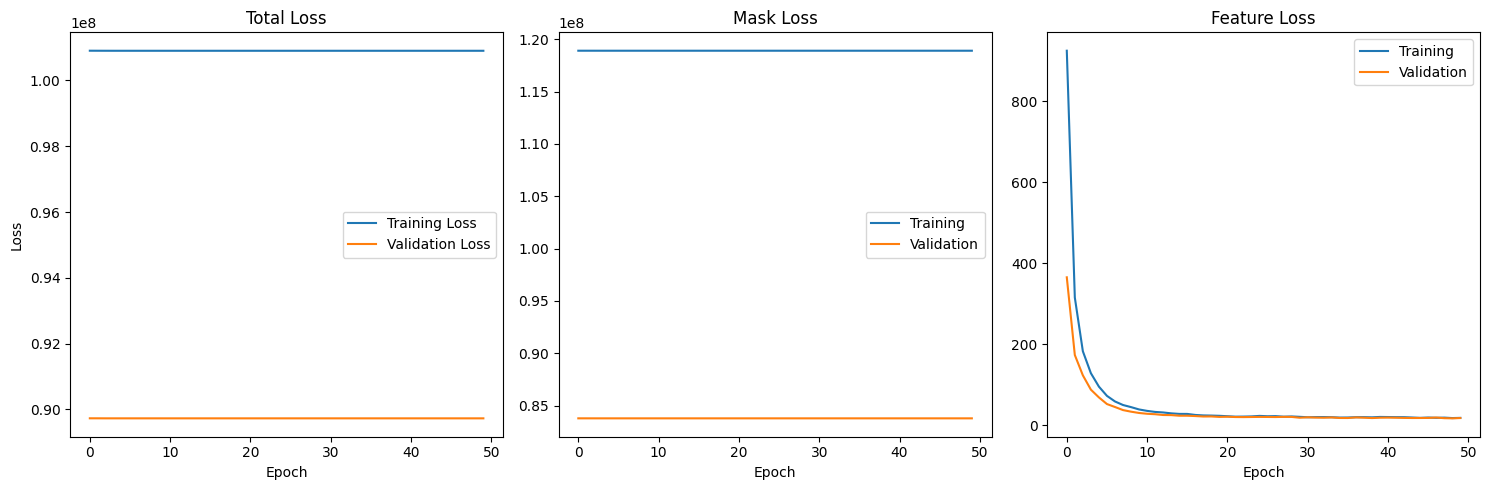

In [51]:
# Step 6: Model training and prediction
print("\n[6/6] Model training and prediction")

if method == 'ensemble':
    # Prepare data for ensemble modeling
    features = [col for col in train_final.columns if col != 'id' and col != 'sii']
    X_train = train_final[features]
    y_train = train_final['sii']
    X_test = test_final[features]
    
    # Train ensemble model
    trainer = ModelTrainer(n_folds=5, random_state=2025)
    results = trainer.train_ensemble(X_train, y_train, X_test)
    
    # Get predictions
    test_predictions = results['test_predictions']
    
else:  # VIME semi-supervised approach
    # Initialize VIME learner
    vime = VIMESemiSupervisedLearner(p_m=0.3, alpha=2.0, beta=1.0, K=3, random_state=2025)
    
    # Prepare data for VIME
    data_dict = vime.prepare_data(train_final, test_final, target_col='sii')
    
    # Train self-supervised model
    encoder = vime.train_self_supervised(
        data_dict['X_unlabeled'],
        epochs=50,
        batch_size=128,
        validation_split=0.1
    )
    
    # Train semi-supervised model
    vime_results = vime.train_semi_supervised(
        data_dict,
        encoder_path='saved_models/vime_encoder.h5',
        hidden_dim=64,
        learning_rate=0.001,
        iterations=1000,
        batch_size=64,
        patience=100
    )
    
    # Get test predictions
    test_predictions = vime_results['test_preds']
    results = vime_results

# Create submission file
submission = pd.DataFrame({
    'id': test_final['id'],
    'sii': test_predictions
})

# Save submission
submission_file = f'submission_{method}.csv'
submission.to_csv(submission_file, index=False)
print(f"\nSubmission file created: {submission_file} with {len(submission)} predictions")

print("\n" + "="*80)
if method == 'ensemble':
    print(f"PIPELINE COMPLETED - Final CV Kappa: {results['final_kappa']:.4f}")
else:
    print(f"PIPELINE COMPLETED - VIME Overall Kappa: {results['overall_kappa']:.4f}")
print("="*80 + "\n")



In [ ]:
 print(f"VIME Method Kappa: {vime_results['overall_kappa']:.4f}")

In [ ]:
# # Run both methods and compare results
# if __name__ == "__main__":
#     # # Run ensemble method
#     # ensemble_results = main(method='ensemble')
    
#     # Run VIME method
#     vime_results = main(method='vime')
#     print(f"VIME Method Kappa: {vime_results['overall_kappa']:.4f}")
    
#     # # Compare the two approaches
#     # print("\n" + "="*80)
#     # print("COMPARING ENSEMBLE AND VIME APPROACHES")
#     # print("="*80)
    
#     # if 'final_kappa' in ensemble_results and 'overall_kappa' in vime_results:
#     #     print(f"Ensemble Method Kappa: {ensemble_results['final_kappa']:.4f}")
#     #     print(f"VIME Method Kappa: {vime_results['overall_kappa']:.4f}")
        
#     #     if ensemble_results['final_kappa'] > vime_results['overall_kappa']:
#     #         print("Ensemble method performed better.")
#     #     else:
#     #         print("VIME method performed better.")
    
#     # print("\nBoth methods have been completed and submission files generated.")
#     print("Review the plots directory for visualizations from both approaches.")

In [ ]:
columns_to_drop = ['PCIAT-PCIAT_02',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_16',
 'PCIAT-Season',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_Total',
 'PCIAT-PCIAT_10',
 'sii',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_14']